
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 1<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Symbolic Regression <br>


### Full Name: Danial Parnian

---

# Introduction

This notebook explores two methods for performing symbolic regression, focusing on both traditional and modern AI-driven approaches:

## 1. EQL-Based Symbolic Regression  
The first approach we implement is based on **Equation Learner (EQL)**, a neural network-based symbolic regression technique. EQL leverages neural networks with activation functions that encourage the discovery of symbolic expressions, making it a differentiable and trainable approach for learning equations directly from data. This method helps in bridging the gap between deep learning and symbolic reasoning.

## 2. Seq2Seq-Based Symbolic Regression with Transformers
A more recent and powerful approach to symbolic regression leverages Sequence-to-Sequence (Seq2Seq) models using Transformers. In this method, we frame symbolic regression as a translation problem, where the input consists of numerical data points and the output is a corresponding mathematical expression. By training a Transformer model on pairs of input data and symbolic expressions, we can enable it to generalize and infer underlying symbolic patterns. This approach benefits from the self-attention mechanism, allowing it to capture long-range dependencies in mathematical structures effectively.


# Datasets

We use two datasets to evaluate our methods:

- **Dataset 1:** This dataset is provided in the notebook, and its underlying mathematical formula is explicitly given. It serves as a reference to assess the performance of different symbolic regression approaches. The expression we consider is: `2 * x + np.sin(x) + x * np.sin(x)`.
  
- **Dataset 2:** This dataset is also provided with the notebook, but its underlying mathematical relationship is hidden. Throughout different parts of the notebook, you will attempt to uncover the equation governing this dataset. Your responses will be evaluated based on how accurately you recover the true formula.

By working through both datasets, we aim to test the robustness and accuracy of various symbolic regression techniques while providing an engaging and exploratory learning experience.

# Import Libraries

In [1]:
import pickle
import numpy as np
import sympy as sp
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from inspect import signature
import time
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sympy
import scipy
import glob
import time
import signal
import random
import warnings
import json
import re

warnings.filterwarnings('ignore')

# Generate Dataset

In [2]:
def generate_data(func, N, range_min=-2, range_max=2, noise_std=0.1):
    """
    Generates a dataset by evaluating the given function on random input values with added noise.

    Parameters:
    func (callable): A function that takes numerical inputs and returns a scalar output.
    N (int): The number of data points to generate.
    range_min (float, optional): The minimum value of the input range. Default is -2.
    range_max (float, optional): The maximum value of the input range. Default is 2.
    noise_std (float, optional): Standard deviation of Gaussian noise added to function outputs. Default is 0.1.

    Returns:
    tuple: A tuple (x, y) where:
        - x (torch.Tensor): A tensor of shape (N, x_dim), where x_dim is the number of inputs to func.
        - y (torch.Tensor): A tensor of shape (N, 1) containing the noisy function outputs.
    """

    x_dim = len(signature(func).parameters)  # Number of inputs to the function
    x = (range_max - range_min) * torch.rand([N, x_dim]) + range_min
    y = torch.tensor([[func(*x_i)] for x_i in x], dtype=torch.float32)

    # Adding Gaussian noise
    noise = torch.randn(y.shape) * noise_std
    y_noisy = y + noise

    return x, y_noisy

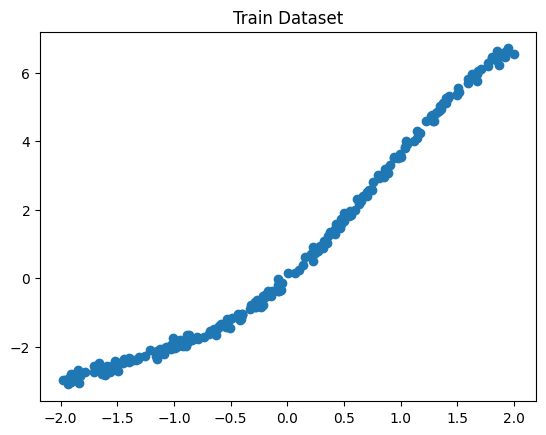

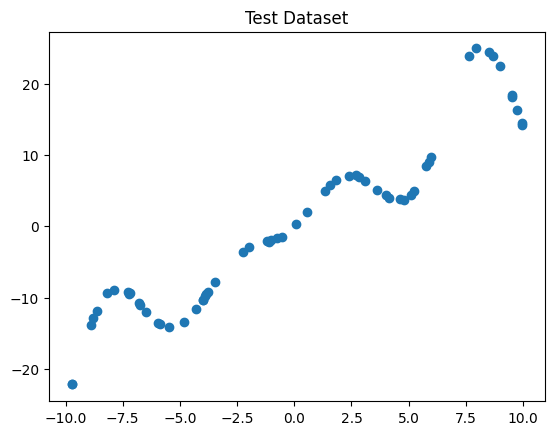

In [3]:
# Define train and test first dataset

x_train, y_train = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 240, -2, 2)
plt.scatter(x_train, y_train)
plt.title('Train Dataset')
plt.show()

# We change range_min and range_max here to test its OOD (out-of-distribution) performance

x_test, y_test = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 60, -10, 10)
plt.scatter(x_test, y_test)
plt.title('Test Dataset')
plt.show()

# EQL

Equation Learner (EQL) is a neural network-based approach to symbolic regression that discovers mathematical expressions directly from data. Unlike traditional deep learning models that treat regression as a black-box approximation, EQL is designed to output interpretable symbolic expressions. EQL uses a special type of neural network where activation functions are not just standard non-linearities (like ReLU or sigmoid) but include mathematical operations such as addition, multiplication, and trigonometric functions (e.g., sin(x), cos(x)).

<p align="center">
  <img style="margin-top: 30px" src="https://camo.githubusercontent.com/f4722b552bd6d4bd3909ff054ebef8bc4a973d9dd93e2ccacd6c77f4e03e3443/68747470733a2f2f692e696d6775722e636f6d2f485a58776656492e706e67" width="1000">
</p>

### Retrieve expressions

This cell is used to retrieve expressions from the network. Do not modify this cell.

In [4]:
"""
Generate a mathematical expression for the symbolic regression get_expression (also known as the EQL network) using SymPy.
This expression can be utilized for pretty-printing in various formats, including human-readable text and LaTeX.
Additionally, SymPy enables algebraic manipulation of the expression.
"""


def apply_activation(W, funcs, n_double=0):
    """Given an (n, m) matrix W and (m) vector of funcs, apply funcs to W.

    Arguments:
        W:  (n, m) matrix
        funcs: list of activation functions (SymPy functions)
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        SymPy matrix with 1 column that represents the output of applying the activation functions.
    """
    W = sp.Matrix(W)
    if n_double == 0:
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j] = funcs[j](W[i, j])
    else:
        W_new = W.copy()
        out_size = len(funcs)
        for i in range(W.shape[0]):
            in_j = 0
            out_j = 0
            while out_j < out_size - n_double:
                W_new[i, out_j] = funcs[out_j](W[i, in_j])
                in_j += 1
                out_j += 1
            while out_j < out_size:
                W_new[i, out_j] = funcs[out_j](W[i, in_j], W[i, in_j+1])
                in_j += 2
                out_j += 1
        for i in range(n_double):
            W_new.col_del(-1)
        W = W_new
    return W


def sym_pp(W_list, funcs, var_names, threshold=0.01, n_double=0):
    """Pretty print the hidden layers (not the last layer) of the symbolic regression network

    Arguments:
        W_list: list of weight matrices for the hidden layers
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        Simplified sympy expression.
    """
    vars = []
    for var in var_names:
        if isinstance(var, str):
            vars.append(sp.Symbol(var))
        else:
            vars.append(var)
    expr = sp.Matrix(vars).T
    # W_list = np.asarray(W_list)
    for W in W_list:
        W = filter_mat(sp.Matrix(W), threshold=threshold)
        expr = expr * W
        expr = apply_activation(expr, funcs, n_double=n_double)
    # expr = expr * W_list[-1]
    return expr


def last_pp(eq, W):
    """Pretty print the last layer."""
    return eq * filter_mat(sp.Matrix(W))


def count_inputs(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction):
            i += 1
        elif isinstance(func, BaseFunction2):
            i += 2
    return i


def count_double(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction2):
            i += 1
    return i


def get_expression(weights, funcs, var_names, threshold=0.01):
    """Pretty print the entire symbolic regression network.

    Arguments:
        weights: list of weight matrices for the entire network
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.

    Returns:
        Simplified sympy expression."""
    n_double = count_double(funcs)
    funcs = [func.sp for func in funcs]

    expr = sym_pp(weights[:-1], funcs, var_names, threshold=threshold, n_double=n_double)
    expr = last_pp(expr, weights[-1])
    expr = expr[0, 0]
    return expr


def filter_mat(mat, threshold=0.01):
    """Remove elements of a matrix below a threshold."""
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i, j]) < threshold:
                mat[i, j] = 0
    return mat


def filter_expr(expr, threshold=0.01):
    expr_new = sp.Integer(0)
    for arg in expr.args:
        if arg.is_constant() and abs(arg) > threshold:   # hack way to check if it's a number
            expr_new = expr_new + arg
        elif not arg.is_constant() and abs(arg.args[0]) > threshold:
            expr_new = expr_new + arg
    return expr_new


def filter_expr2(expr, threshold=0.01):
    for a in sp.preorder_traversal(expr):
        if isinstance(a, sp.Float) and a < threshold:
            expr = expr.subs(a, 0)
    return expr

### Base Functions
These cells contain functions for use in symbolic regression. Each function encapsulates multiple implementations (SymPy, Torch) of a particular operation, allowing them to be used in different contexts. You need to complete the Torch sections.

In [5]:
"""Functions for use with symbolic regression.

These functions encapsulate multiple implementations (sympy, torch) of a particular function so that the
functions can be used in multiple contexts."""

class BaseFunction:
    """Abstract class for primitive functions"""
    def __init__(self, norm=1):
        self.norm = norm

    def sp(self, x):
        """Sympy implementation"""
        return None

    def torch(self, x):
        """No need for base function"""
        return None

    def name(self, x):
        return str(self.sp)


class Constant(BaseFunction):
    def torch(self, x):
        return torch.ones_like(x)

    def sp(self, x):
        return 1


class Identity(BaseFunction):
    """
    A function class that applies an identity transformation with normalization.

    Attributes:
    norm (float): A normalization factor that scales the input.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the identity transformation by dividing the input by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the identity function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The normalized output tensor.

        """
        return x / self.norm

    def sp(self, x):
        return x / self.norm



class Square(BaseFunction):
    """
    A function class that applies a squared transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Returns the squared value of the input, divided by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the squared function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The squared output tensor divided by the normalization factor.
        """
        return x ** 2 / self.norm


    def sp(self, x):
        return x ** 2 / self.norm


class Pow(BaseFunction):
    """
    A function class that raises the input to a given power and normalizes the result.

    Attributes:
    power (float): The exponent to which the input is raised.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Raises the input to the specified power and divides by the normalization factor.
    """

    def __init__(self, power: float, norm: float = 1):
        """
        Initializes the Pow function with a given exponent and normalization factor.

        Parameters:
        power (float): The exponent for the power function.
        norm (float, optional): The normalization factor. Default is 1.
        """

        BaseFunction.__init__(self, norm=norm)
        self.power = power

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the power function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor, where each element is raised to the given power and normalized.
        """
        x ** self.power / self.norm

    def sp(self, x):
        return x ** self.power / self.norm


class Sin(BaseFunction):
    """
    A function class that applies a sine transformation with frequency scaling and normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies a sine transformation to the input and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sine function with frequency scaling and normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sine-transformed tensor divided by the normalization factor.
        """
        return torch.sin(x * 2 * 2 * np.pi) / self.norm

    def sp(self, x):
        return sp.sin(x * 2*2*np.pi) / self.norm


class Sigmoid(BaseFunction):
    """
    A function class that applies the sigmoid function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the sigmoid function and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sigmoid function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sigmoid-transformed tensor divided by the normalization factor.
        """
        return (1 / (1 + torch.exp(-20 * x))) / self.norm

    def sp(self, x):
        return 1 / (1 + sp.exp(-20*x)) / self.norm

    def name(self, x):
        return "sigmoid(x)"


class Exp(BaseFunction):
    """
    A function class that applies an exponential transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the exponential function (subtracting 1) and divides by the normalization factor.
    """

    def __init__(self, norm: float = np.e):
        """
        Initializes the Exp function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is Euler's number (e).
        """
        super().__init__(norm)

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the modified exponential function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The transformed tensor, where exp(x) - 1 is computed and divided by the normalization factor.
        """
        return (torch.exp(x) - 1) / self.norm

    def sp(self, x):
        return (sp.exp(x) - 1) / self.norm


class Log(BaseFunction):
    """
    A function class that applies the logarithm function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the logarithm function (on the absolute value of input) and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the logarithm function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The log-transformed tensor divided by the normalization factor.
        """
        return torch.log(torch.abs(x)) / self.norm

    def sp(self, x):
        return sp.log(sp.Abs(x)) / self.norm


class BaseFunction2:
    """Abstract class for primitive functions with 2 inputs"""
    def __init__(self, norm=1.):
        self.norm = norm

    def sp(self, x, y):
        """Sympy implementation"""
        return None

    def torch(self, x, y):
        return None

    def name(self, x, y):
        return str(self.sp)


class Product(BaseFunction2):
    """
    A function class that computes the product of two inputs with normalization.

    Methods:
    torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        Computes the product of two input tensors and divides by the normalization factor.
    """

    def __init__(self, norm: float = 0.1):
        """
        Initializes the Product function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is 0.1.
        """
        super().__init__(norm=norm)

    def torch(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes the product of two input tensors with normalization.

        Parameters:
        x (torch.Tensor): The first input tensor.
        y (torch.Tensor): The second input tensor.

        Returns:
        torch.Tensor: The element-wise product of x and y, divided by the normalization factor.
        """
        return x * y / self.norm

    def sp(self, x, y):
        return x * y / self.norm



### Model Architecture

In this section, we define the architecture of the symbolic regression neural network using the Equation Learner (EQL) approach. The model is designed to learn mathematical expressions by incorporating activation functions that correspond to primitive mathematical operations.

1. SymbolicLayer: Each layer applies a set of predefined functions (e.g., sin(x), cos(x), x^2, etc.). The weight matrix determines how input features are transformed and combined. Functions are applied either as single-input (f(x)) or double-input (f(x, y)) operations.

2. SymbolicNet: Composed of multiple SymbolicLayer instances. Uses trainable weight matrices to learn meaningful expressions. The final layer outputs a weighted sum without an activation function.

In [6]:
"""Contains the symbolic regression neural network architecture."""
import numpy as np
import torch
import torch.nn as nn

class SymbolicLayer(nn.Module):
    """Neural network layer for symbolic regression where activation functions correspond to primitive functions.
    Can take multi-input activation functions (like multiplication)"""
    def __init__(self, funcs, initial_weight=None, init_stddev=0.1, in_dim=None):
        """
        funcs: List of activation functions, using utils.functions
        initial_weight: (Optional) Initial value for weight matrix
        variable: Boolean of whether initial_weight is a variable or not
        init_stddev: (Optional) if initial_weight isn't passed in, this is standard deviation of initial weight

        Parameters need to define:

        - self.W: The weight matrix of the layer. It maps the input features to the output functions. If an `initial_weight` is provided, it is used as the initial weight matrix.
                  Otherwise, it is initialized from a normal distribution with mean 0 and standard deviation `init_stddev`.
        """
        super().__init__()

        self.output = None  # tensor for layer output

        self.n_funcs = len(funcs)                       # Number of activation functions (and number of layer outputs)
        self.funcs = [func.torch for func in funcs]     # Convert functions to list of PyTorch functions

        self.n_double = count_double(funcs)   # Number of activation functions that take 2 inputs
        self.n_single = self.n_funcs - self.n_double    # Number of activation functions that take 1 input

        self.out_dim = self.n_funcs + self.n_double

        # Define and initialize the weight matrix `W`.
        # If `initial_weight` is provided, use it; otherwise, initialize with a normal distribution.
        if initial_weight is not None:
            self.W = nn.Parameter(torch.tensor(initial_weight, dtype=torch.float32))
        else:
            self.W = nn.Parameter(torch.randn(in_dim, self.out_dim) * init_stddev)

    def forward(self, x):
        """
        Computes the forward pass of the layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

        Returns:
            torch.Tensor: Output tensor after applying the symbolic functions.

        Process:
            1. Multiply input `x` with weight matrix `W` to get weighted sum `g`.
            2. Apply the activation functions:
               - Single-input functions take one element from `g`.
               - Two-input functions take two elements from `g` and produce a single output.
            3. Stack all function outputs into a single tensor.
        """
        g = x @ self.W  # Weighted sum
        outputs = []

        # Apply single-input functions
        for i in range(self.n_single):
            outputs.append(self.funcs[i](g[:, i]))

        # Apply double-input functions
        for i in range(self.n_double):
            idx = self.n_single + i
            outputs.append(self.funcs[idx](g[:, idx], g[:, idx + 1]))

        return torch.stack(outputs, dim=1)

    def get_weight(self):
        return self.W.cpu().detach().numpy()

    def get_weight_tensor(self):
        return self.W.clone()


class SymbolicNet(nn.Module):
    """Symbolic regression network with multiple layers. Produces one output."""
    def __init__(self, symbolic_depth, in_dim=1, funcs=None, initial_weights=None, init_stddev=0.1):
        super(SymbolicNet, self).__init__()

        """
        Initializes the symbolic regression network.

        Parameters:
        symbolic_depth (int): The number of hidden layers in the network.
        funcs (list): A list of functions to be used in each layer of the network.
        initial_weights (list or None): Predefined initial weights for each layer. If None, the network will initialize weights randomly.
        init_stddev (float or list): Standard deviation for weight initialization. If a list, each layer will have its own stddev for initialization.

        Hints:
        The first layer will have 1 input dimension (the data itself), and subsequent layers will have the same number of functions as the depth.
        If predefined weights are provided, initialize layers with those weights. otherwise Initialize the network randomly if no initial weights are provided.
        Don't foget to Initialize the output weight (no activation function applied there).

        **Parametrs to define** :

        - self.depth: The number of hidden layers in the network. It determines how many `SymbolicLayer` instances are stacked in the model.

        - self.hidden_layers: A sequential container (`nn.Sequential`) that stores the hidden layers of the network.
                              Each layer is an instance of `SymbolicLayer`, and they are initialized with the provided  activation functions and weights.

        - self.output_weight: A parameter representing the weight matrix for the final layer, mapping the last hidden  layer's output to a single output value.
                              This weight is either initialized from  `initial_weights` (if provided) or randomly initialized when `initial_weights` is None.
        """
        self.depth = symbolic_depth
        self.hidden_layers = nn.ModuleList()

        # Initialize hidden layers
        for i in range(self.depth):
            layer_in_dim = in_dim if i == 0 else self.hidden_layers[i-1].n_funcs
            initial_weight = initial_weights[i] if initial_weights else None
            self.hidden_layers.append(SymbolicLayer(funcs, initial_weight, init_stddev, layer_in_dim))

        # Initialize output weight
        output_in_dim = self.hidden_layers[-1].n_funcs
        if initial_weights and len(initial_weights) > symbolic_depth:
            self.output_weight = nn.Parameter(torch.tensor(initial_weights[-1], dtype=torch.float32))
        else:
            self.output_weight = nn.Parameter(torch.randn(output_in_dim, 1) * init_stddev)


    def forward(self, input):
        """
        Defines the forward pass of the network.

        Parameters:
        input (Tensor): The input tensor to the network.

        Returns:
        Tensor: Final output of the network after passing through all layers
        """
        x = input
        for layer in self.hidden_layers:
            x = layer(x)
        return x @ self.output_weight


    def get_weights(self):
        """Return list of weight matrices"""
        # First part is iterating over hidden weights. Then append the output weight.
        return [self.hidden_layers[i].get_weight() for i in range(self.depth)] + \
               [self.output_weight.cpu().detach().numpy()]

    def get_weights_tensor(self):
        """Return list of weight matrices as tensors"""
        return [self.hidden_layers[i].get_weight_tensor() for i in range(self.depth)] + \
               [self.output_weight.clone()]



### Training phase

In [7]:
def train(
        x_train,  # Tensor: Input training data
        y_train,  # Tensor: Target training data
        activation_funcs,  # List of activation functions for each layer
        in_dim,  # input dimension
        n_layers,  # Integer: Number of layers in the symbolic regression network
        learning_rate,  # Float: Learning rate for optimization
        summary_step,  # Integer: Interval for logging training progress
        epochs,  # Integer: Number of training epochs
        reg_weight_l1=0.0,  # Float: L1 regularization weight
        device="cuda"  # String: Device to perform training on ("cuda" for GPU, "cpu" otherwise)
):
    """
    This function trains a symbolic regression network using the provided training data.

    Returns:
    - net: The trained symbolic regression network.
    """
    # Move data to the specified device
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Initialize the symbolic regression network
    net = SymbolicNet(symbolic_depth=n_layers, in_dim=in_dim, funcs=activation_funcs).to(device)

    # Define the optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        net.train()  # Set the model to training mode
        optimizer.zero_grad()  # Clear gradients from the previous step

        # Forward pass
        outputs = net(x_train)
        mse_loss = F.mse_loss(outputs, y_train)  # Mean squared error loss

        # Add L1 regularization term
        l1_reg = sum(torch.sum(torch.abs(param)) for param in net.parameters())
        loss = mse_loss + reg_weight_l1 * l1_reg

        # Check for NaN loss and restart training if necessary
        if np.isnan(loss.item()):
            print(f"nan loss occurred at epoch {epoch}. restart training.")
            return train(x_train, y_train, activation_funcs, in_dim, n_layers, learning_rate, summary_step, epochs,
                         reg_weight_l1, device)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Log progress
        if (epoch + 1) % summary_step == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return net


def test(net, x_test, y_test, device="cuda"):
    """
    This function tests a symbolic regression network using the provided test data.

    Parameters:
    - net: The trained symbolic regression network (instance of SymbolicNet).
    - x_test: Tensor, the input test data.
    - y_test: Tensor, the target test data.
    - device: String, the device where the test will occur (default is "cuda" for GPU).

    Returns:
    - test_loss: test loss value.
    """

    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():  # test error
        test_outputs = net(x_test)
        test_loss = F.mse_loss(test_outputs, y_test)

    if np.isnan(test_loss.item()):
        return float('inf')
    return test_loss.item()



In [8]:
# Define the function that evaluates the expression
def symbolic_function(expr_str, x):
    return eval(expr_str, {"x_1": x, "x1": x, "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp})

# Function to plot the symbolic regression output and test dataset
def plot_symbolic(x_test, y_test, expr_str):
    x_values = np.linspace(-10, 10, 50)
    y_values = np.array([symbolic_function(expr_str, x) for x in x_values])

    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, label="Symbolic Regression Output", color='b')
    plt.scatter(x_test, y_test, label="Test Dataset", color='r', s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best results of Symbolic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def find_expression(net, x_dim):
  with torch.no_grad():
      weights = net.get_weights()
      expr_str = get_expression(weights, activation_funcs, var_names[:x_dim])
      return expr_str


def run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials = 10, reg_weight=0.0):
    """
    This function runs the training and testing process for multiple trials.

    The function performs the following steps:
    1. **Training and Testing**: The symbolic regression network is trained and tested for a specified number of trials (default is 10). In each trial:
        - A new model is initialized and trained on the provided training data (`x_train`, `y_train`).
        - The model is then evaluated on the test data (`x_test`, `y_test`) to calculate the test loss (Mean Squared Error).
        - The corresponding symbolic expression is extracted using the `find_expression` function.

    2. **Trial Comparison**: After running all the trials, the best model is selected based on the lowest test loss. This ensures that the model with the best generalization performance is chosen.

    3. **Result Plotting**: The symbolic expression corresponding to the model with the lowest test loss is plotted using the `plot_symbolic` function. The expression is processed to ensure compatibility with NumPy functions (e.g., replacing `exp` with `np.exp` and `sin` with `np.sin`).


    Parameters:
    - No parameters; the function assumes `x_train`, `x_test`, `y_train`, and `y_test` are already defined globally or passed externally.

    Returns:
    - None: The function performs training and testing, logs results, and plots the best model's symbolic expression.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    expressions = []
    losses = []

    for t in range(trials):
        print(f"trial {t + 1} / {trials}")

        # Train the model
        net = train(
            x_train=x_train,
            y_train=y_train,
            activation_funcs=activation_funcs,
            in_dim=x_train.shape[1],
            n_layers=n_layers,
            learning_rate=learning_rate,
            summary_step=summary_step,
            epochs=epochs,
            reg_weight_l1=reg_weight,
            device=device
        )

        # Test the model
        test_loss = test(net, x_test, y_test, device=device)
        losses.append(test_loss)

        # Extract the symbolic expression
        expr_str = find_expression(net, x_train.shape[1])
        expressions.append(expr_str)

        print(f"Test Loss: {test_loss:.4f}")
        print(f"Expression: {expr_str}")

    # Find the best trial
    best_index = np.argmin(np.array(losses))
    best_expr = expressions[best_index]

    print("\nBest Trial:")
    print(f"test loss: {losses[best_index]:.4f}")
    print(f"expression: {best_expr}")

    # Plot the best result
    # plot_symbolic(x_test.cpu().numpy(), y_test.cpu().numpy(), best_expr)

    return str(best_expr)



trial 1 / 5
Epoch [200/1000], Loss: 0.0090
Epoch [400/1000], Loss: 0.0087
Epoch [600/1000], Loss: 0.0086
Epoch [800/1000], Loss: 0.0086
Epoch [1000/1000], Loss: 0.0086
Test Loss: 234938925056.0000
Expression: -0.0232303854336944*x_1**2 + 0.0938103*x_1 + 0.0232636*(0.0459996966233833*x_1**2 - 0.177513*x_1 - 0.42819*sin(0.930594257386138*x_1) - 0.175381*sin(0.93253588907432*x_1) - 1 - 0.166783/(exp(1.99341*x_1) + 1) - 0.588534/(1 + exp(-3.23604*x_1)))**2 + 0.0124973*(-0.0386310820999116*x_1**2 + 0.0607338*x_1 + 0.298209734969014*exp(0.186527*x_1) + sin(0.930594257386138*x_1) + 0.557763*sin(0.93253588907432*x_1) + 0.841620095234503 - 0.177163632548802*exp(-0.452085*x_1) - 0.571189/(exp(1.99341*x_1) + 1))**2 - 2.5227352976799*(-0.00906298043769752*x_1**2 + 0.0709799*x_1 + 0.0937279492293232*exp(0.186527*x_1) + 0.129549*sin(0.930594257386138*x_1) + 0.085653*sin(0.93253588907432*x_1) + 0.172005263003267 + 0.200696/(exp(1.99341*x_1) + 1) + 0.0939868/(1 + exp(-3.23604*x_1)))*(-0.00422846751696

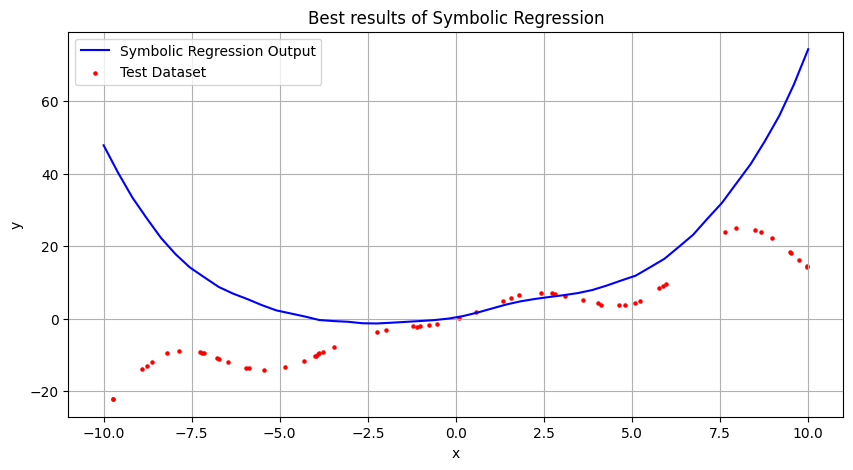

In [10]:
activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    *[Product()] * 2,
]


var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.


n_layers = 2  # Number of hidden layers
reg_weight = 0.0  # Regularization weight
learning_rate = 0.008  # Learning rate
summary_step = 200  # Number of steps between logging summaries
epochs = 1000  # Number of epochs
trials = 5  # Number of trials

best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials, reg_weight)
plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


Testing for n_layers=2
________________________________________________________
trial 1 / 5
Epoch [200/1000], Loss: 0.0089
Epoch [400/1000], Loss: 0.0088
Epoch [600/1000], Loss: 0.0088
Epoch [800/1000], Loss: 0.0088
Epoch [1000/1000], Loss: 0.0088
Test Loss: 1787.5051
Expression: 0.00149270122802427*x_1**2 + 0.0558167*x_1 + 0.00339829*(0.0440187180987549*x_1**2 - 0.619675*x_1 - sin(0.552534608609985*x_1) - 0.160677095674874 + 0.134904632478323*exp(-0.115007*x_1) + 0.990089/(exp(4.21652*x_1) + 1) - 0.997983/(1 + exp(-2.51137*x_1)))**2 + 0.0238088*(-0.00921943487054684*x_1**2 + 0.280064*x_1 + sin(0.552534608609985*x_1) + 0.290346*sin(0.963377198241498*x_1) + 0.957218786714467 + 0.0217495249254478*exp(-0.115007*x_1) - 0.267997/(exp(4.21652*x_1) + 1) + 0.594913/(1 + exp(-2.51137*x_1)))**2 - 1.29784747958183*(-0.0312126512090749*x_1**2 - 0.0540128*x_1 - 0.055165445466736*exp(0.107806*x_1) - 0.0256173*sin(0.552534608609985*x_1) - 0.192325*sin(0.963377198241498*x_1) - 0.231420626578414 - 0.05

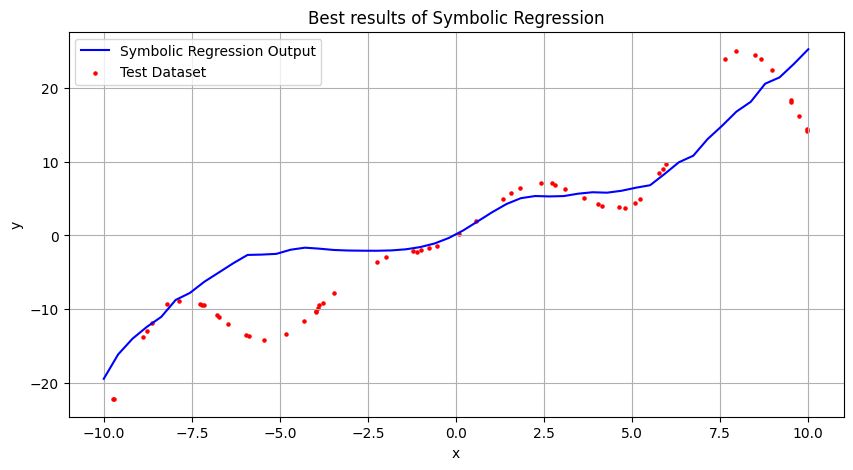

Testing for n_layers=3
________________________________________________________
trial 1 / 5
Epoch [200/1000], Loss: 0.0088
Epoch [400/1000], Loss: 0.0087
Epoch [600/1000], Loss: 0.0087
Epoch [800/1000], Loss: 0.0087
Epoch [1000/1000], Loss: 0.0087
Test Loss: 710.0180
Expression: 0.00574197915446792*x_1**2 + 0.0330268*x_1 + 1.57526362833848*(-0.00745948510963049*x_1**2 - 0.0163203*x_1 - 0.0862434*sin(0.491969331994539*x_1) - 0.0348747068302571 + 0.0363506480545379*exp(-0.0923447*x_1) - 0.0128659269048609*exp(-0.050304*x_1) - 0.159013/(1 + exp(-2.84757*x_1)))*(0.000334617023938498*x_1**2 + 0.0696572*x_1 + 0.0842744*sin(0.491969331994539*x_1) - 0.0163731336795776 - 0.00963111427888834*exp(-0.0923447*x_1) - 0.0507256010224377*exp(-0.050304*x_1) + 0.013/(1 + exp(-2.84757*x_1))) - 0.0192822782785467*(-0.0447577708424416*x_1**2 + 0.318082028474465*x_1 + 0.87412791532086*sin(0.491969331994539*x_1) - 1 - 0.189682575938088*exp(-0.0923447*x_1) - 0.256176903942713*exp(-0.050304*x_1) - 0.0380723533

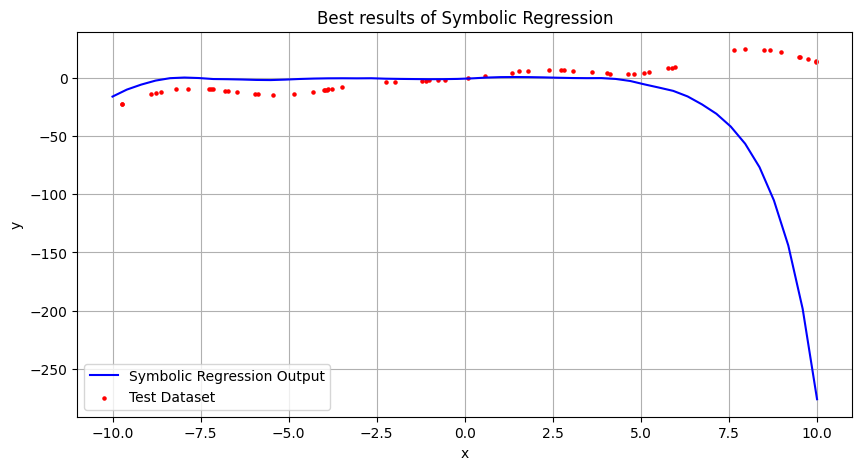

Testing for n_layers=4
________________________________________________________
trial 1 / 5
Epoch [200/1000], Loss: 0.0089
Epoch [400/1000], Loss: 0.0088
Epoch [600/1000], Loss: 0.0088
Epoch [800/1000], Loss: 0.0087
Epoch [1000/1000], Loss: 0.0092
Test Loss: 782157.0000
Expression: -2.35224392426882e-5*x_1**2 + 0.00136034*x_1 + 0.156328495980252*(0.0199429408384533*x_1**2 - 0.00702935*x_1 + 0.171922*sin(0.440654004470887*x_1) - 0.0378249068511431 + 0.0677158505218293*exp(-0.054559*x_1) - 0.0284355174545607*exp(-0.024208*x_1) + 0.063465/(1 + exp(-1.98548*x_1)) + 0.082246/(1 + exp(-2.4275*x_1)))*(-0.00882264753300636*x_1**2 - 0.0269551*x_1 + 0.128437*sin(0.402321197149884*x_1) + 0.039125*sin(0.440654004470887*x_1) - 0.287286882769052 + 0.020245786872132*exp(-0.054559*x_1) + 0.0574075965129933*exp(-0.024208*x_1) - 0.205156/(1 + exp(-1.98548*x_1)) - 0.0336205/(1 + exp(-2.4275*x_1))) + 0.000893895*(-0.195867525106268*x_1**2 - 0.230652*x_1 - 0.588865*sin(0.402321197149884*x_1) - 0.249191*sin

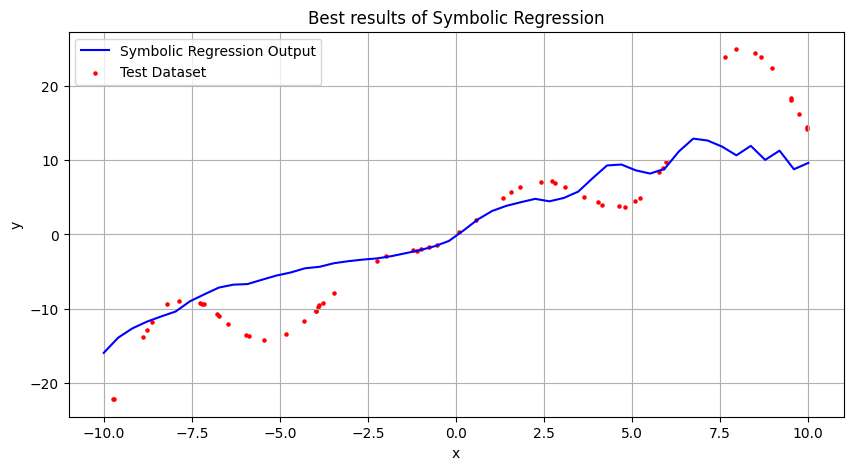

In [11]:
# Now, change the activation functions and the number of layers (n_layers) to observe the effect on the outputs.

for n_layers in range(2, 5):
    print(f"Testing for n_layers={n_layers}")
    print("________________________________________________________")
    best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
    plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


We were previously working with the first dataset. Now, evaluate the model on the second dataset and extract the corresponding expression.

In [12]:
# Load custom dataset
df = pd.read_csv("./dataset.csv")
y = torch.tensor(df.iloc[:, 0].values.reshape(-1, 1), dtype=torch.float32)
x = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32)

# Split the dataset using train_test_split
SEED = 42  # Random seed for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=SEED)
n_layers = 2  # Number of hidden layers
reg_weight = 0.0  # Regularization weight
learning_rate = 0.008  # Learning rate
summary_step = 200  # Number of steps between logging summaries
epochs = 1000  # Number of epochs
trials = 5  # Number of trials

# Run the model on the dataset and plot
best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
# plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))


trial 1 / 5
Epoch [200/1000], Loss: 223.2289
Epoch [400/1000], Loss: 67.0621
Epoch [600/1000], Loss: 17.6489
Epoch [800/1000], Loss: 9.8025
Epoch [1000/1000], Loss: 9.7191
Test Loss: 348.1601
Expression: 0.237279*x_1 + 0.0194314*x_2 + 0.0320422*(-x_1 - 0.850308*x_2)**2 + 0.0801274*(-x_1 - 0.807404*x_2)**2 + 0.00543643*(-x_1 - 0.651194*x_2)**2 + 0.0441654*(-x_1 - 0.401842*x_2)**2 - 3.76754120245405*(-0.133254*x_1 - 0.0545676*x_2)*(0.285015*x_1 + 0.0896389*x_2) + 4.15351240536167*(0.023863*x_1 - 0.273338*x_2)*(0.200351*x_1 - 0.0403535*x_2) + 3.75584185123444*(-0.0117567*x_1 + 0.0323326*x_2 + 0.00552479*(-x_1 - 0.850308*x_2)**2 - 0.0175671*(-x_1 - 0.807404*x_2)**2 + 0.000957688*(-x_1 - 0.651194*x_2)**2 + 0.00354668*(-x_1 - 0.401842*x_2)**2 - 0.456781089305878*(0.023863*x_1 - 0.273338*x_2)*(0.200351*x_1 - 0.0403535*x_2) + 0.0133981551214436*exp(0.0913835*x_1 + 0.0810188*x_2) - 0.0161015789361828*exp(0.126317*x_1 - 0.0868987*x_2) - 0.192809*sin(2.03267902809765*x_1) - 0.163996*sin(0.7275657

### Bonus

We know that in the first and second dataset, the expression is simple and contains only one or at most two terms. However, as you can see, the expressions here are quite long. Now, think about what adjustments you can make to simplify them and reduce their length.

**Answer**: One idea was to increase the threshold parameter in the get_expression or filter_mat functions to remove terms with small contributions. I tried it and did not lead to good results.
A better idea is to add l1-regularization to encourage sparse weights and therefore shorter expressions. I added regularization term to previous functions and in the following cell you'll see how it helps to reach short expressions.

trial 1 / 5
Epoch [200/1000], Loss: 0.4682
Epoch [400/1000], Loss: 0.3091
Epoch [600/1000], Loss: 0.2503
Epoch [800/1000], Loss: 0.2231
Epoch [1000/1000], Loss: 0.2090
Test Loss: 171.2376
Expression: -8.09761822223663*(-0.434694*sin(0.565009999482947*x_1) - 0.497464*sin(0.617962858987807*x_1))*(0.122291*sin(0.617962858987807*x_1) + 0.51628 + 0.326589/(1 + exp(-1.96333*x_1)))
trial 2 / 5
Epoch [200/1000], Loss: 0.5385
Epoch [400/1000], Loss: 0.3250
Epoch [600/1000], Loss: 0.2556
Epoch [800/1000], Loss: 0.2395
Epoch [1000/1000], Loss: 0.2185
Test Loss: 172.7866
Expression: -6.19193136692047*(0.463723*sin(0.594772868848778*x_1) + 0.58184*sin(0.606128905027553*x_1))*(-0.0400605*sin(0.594772868848778*x_1) - 0.0695273*sin(0.606128905027553*x_1) - 0.555312 - 0.177279/(1 + exp(-1.43889*x_1)) - 0.282074/(1 + exp(-1.90836*x_1)))
trial 3 / 5
Epoch [200/1000], Loss: 0.4061
Epoch [400/1000], Loss: 0.2909
Epoch [600/1000], Loss: 0.2372
Epoch [800/1000], Loss: 0.2235
Epoch [1000/1000], Loss: 0.2208
T

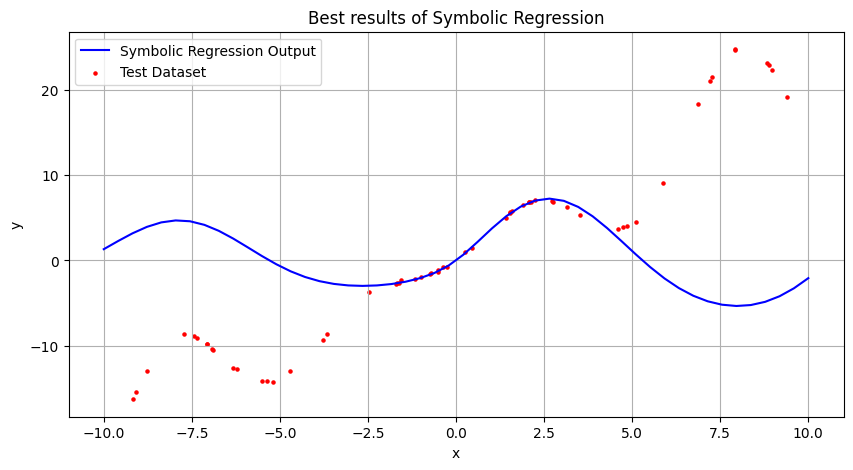

In [32]:
# Test non-zero values for l1 regularization
n_layers = 2  # Number of hidden layers
reg_weight = 0.06  # Regularization weight
learning_rate = 0.008  # Learning rate
summary_step = 200  # Number of steps between logging summaries
epochs = 1000  # Number of epochs
trials = 5  # Number of trials

x_train, y_train = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 240, -2, 2)
x_test, y_test = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 60, -10, 10)

best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials, reg_weight)
plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))

# Seq2Seq-Based Symbolic Regression with Transformers

<p align="center">
  <img style="margin-top: 30px" src="https://cdn.botpenguin.com/assets/website/Sequence_to_Sequence_Models_0b5fb158a1.webp" width="500">
</p>

Symbolic regression is a method that aims to find a mathematical expression that best fits a given dataset. Unlike traditional regression techniques, symbolic regression does not assume a predefined function structure; instead, it searches for an optimal mathematical expression that relates input features to target variables. One effective approach to symbolic regression is using sequence-to-sequence (Seq2Seq) models based on transformers.

### Overview of Seq2Seq Models in Symbolic Regression:
A Seq2Seq model consists of an encoder and a decoder, both of which are typically built using transformer architectures. The main idea is to treat symbolic regression as a sequence translation problem, where:
- The input is a set of numerical data points (features).
- The output is a mathematical expression represented as a sequence of tokens.
- This approach allows the model to learn a mapping from numerical inputs to symbolic expressions, making it a powerful tool for symbolic regression.

### Encoder: Processing the Input Data

The encoder in a Seq2Seq transformer is responsible for encoding the full dataset into a latent representation. Here’s how it works:

1. Tokenization: The input dataset (typically a set of feature-value pairs) is transformed into a sequence of tokens. Each token can represent a numerical value or a special marker that indicates structural information.

2. Embedding Layer: The numerical tokens are converted into dense vector representations using an embedding layer.

3. Positional Encoding: Since transformers do not have built-in recurrence mechanisms, positional encodings are added to the embeddings to retain the order of the input sequence.

4. Self-Attention Mechanism: The encoder consists of multiple self-attention layers that allow the model to weigh the importance of different parts of the input sequence dynamically.

5. Output Representation: The encoder outputs a context-aware representation of the input sequence, which is then passed to the decoder.

### Decoder: Generating the Mathematical Expression
The decoder takes the encoder’s output and generates the target sequence, which is a symbolic mathematical expression. This process follows these steps:

1. Input Token Embedding: The decoder receives an initial input token (typically a start-of-sequence token <SOS>).

2. Self-Attention Layers: The decoder generates tokens one by one, attending to previously generated tokens using masked self-attention.

3. Cross-Attention with Encoder Outputs: The decoder also attends to the encoder’s output using cross-attention layers, ensuring that the generated expression is conditioned on the input data.

4. Token Generation via Softmax: The final layer applies a softmax function over the vocabulary (consisting of mathematical symbols, operators, and variables) to predict the next token.


In this section, we will implement symbolic regression using transformers. First, we generate the dataset and save it in the `data` folder. Do not modify the cell below. We suggest reading and understanding it first.

In [14]:
# Don't change this cell.

C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)

MY_VOCAB = np.array([
    ['add', 4, 2],  # binary operators
    ['sub', 3, 2],
    ['mul', 6, 2],
    ['sin', 1, 1],  # unary operators
    ['cos', 1, 1],
    ['log', 2, 1],
    ['exp', 2, 1],
    ['neg', 0, 1],
    ['inv', 3, 1],
    ['sq', 2, 1],
    ['cb', 0, 1],
    ['sqrt', 2, 1],
    ['cbrt', 0, 1],
    ['C', 8, 0],  # leaves
    ['x1', 8, 0],
    ['x2', 8, 0],
    ['x3', 4, 0],
    ['x4', 4, 0],
    ['x5', 2, 0],
    ['x6', 2, 0],
])


def generate_expression(vocab):
    """
    Recursive function!
    Generate one expression using the tokens and their
    respective probabiities provided by 'vocab'.
    """
    weights = vocab[:, 1].astype('float32')
    probs = weights / np.sum(weights)
    N = len(vocab)
    expr = []
    rand_idx = np.random.choice(N, p=probs)
    cur_token = vocab[rand_idx, 0]
    cur_arity = int(vocab[rand_idx, 2])
    expr.append(cur_token)
    if cur_arity==0:
        return expr
    else:
        if cur_token in ['sin', 'cos']:
            idx1 = np.where(vocab[:, 0]=='sin')[0][0]
            idx2 = np.where(vocab[:, 0]=='cos')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        elif cur_token in ['log', 'exp']:
            idx1 = np.where(vocab[:, 0]=='log')[0][0]
            idx2 = np.where(vocab[:, 0]=='exp')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        else:
            new_vocab = vocab
        if cur_arity==1:
            child = generate_expression(new_vocab)
            return expr + child
        elif cur_arity==2:
            child1 = generate_expression(new_vocab)
            child2 = generate_expression(new_vocab)
            return expr + child1 + child2


def translate_integers_into_tokens(seq_int):
    seq_tokens = []
    for n in range(len(seq_int)):
        if seq_int[n]>=2:
            seq_tokens.append(MY_VOCAB[seq_int[n]-2])
    return seq_tokens


def from_sequence_to_sympy(expr):
    """
    Recursive function!
    Convert the initial sequence of tokens into SymPy expression.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])


    cur_token = expr[0]
    try:
        return float(cur_token)  # for cases when constants are evaluated
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        if cur_token=='C':
            return C
        elif cur_token=='x1':
            return x1
        elif cur_token=='x2':
            return x2
        elif cur_token=='x3':
            return x3
        elif cur_token=='x4':
            return x4
        elif cur_token=='x5':
            return x5
        elif cur_token=='x6':
            return x6
    elif cur_arity==1:
        if cur_token=='sin':
            return sympy.sin(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cos':
            return sympy.cos(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='log':
            return sympy.log(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='exp':
            return sympy.exp(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='neg':
            return - from_sequence_to_sympy(expr[1:])
        elif cur_token=='inv':
            return 1 / from_sequence_to_sympy(expr[1:])
        elif cur_token=='sq':
            return (from_sequence_to_sympy(expr[1:]))**2
        elif cur_token=='cb':
            return (from_sequence_to_sympy(expr[1:]))**3
        elif cur_token=='sqrt':
            return sympy.sqrt(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cbrt':
            return sympy.cbrt(from_sequence_to_sympy(expr[1:]))
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return from_sequence_to_sympy(left_list) + from_sequence_to_sympy(right_list)
        elif cur_token=='sub':
            return from_sequence_to_sympy(left_list) - from_sequence_to_sympy(right_list)
        elif cur_token=='mul':
            return from_sequence_to_sympy(left_list) * from_sequence_to_sympy(right_list)


def from_sequence_to_string(expr):
    """
    OBSOLETE
    Recursive function!
    Convert the initial sequence of tokens into a string
    which can be read by SymPy.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])

    cur_token = expr[0]
    try:
        float(cur_token)  # for cases when constants are evaluated
        cur_arity = 0
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        return cur_token
    elif cur_arity==1:
        if cur_token=='inv':
            return '1/(' + from_sequence_to_string(expr[1:]) + ')'
        elif cur_token=='sq':
            return '(' + from_sequence_to_string(expr[1:]) + ')**2'
        elif cur_token=='cb':
            return '(' + from_sequence_to_string(expr[1:]) + ')**3'
        elif cur_token=='neg':
            return '-(' + from_sequence_to_string(expr[1:]) + ')'
        else:
            return cur_token + '(' + from_sequence_to_string(expr[1:]) + ')'
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return '(' + from_sequence_to_string(left_list) + ')+(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='sub':
            return '(' + from_sequence_to_string(left_list) + ')-(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='mul':
            return '(' + from_sequence_to_string(left_list) + ')*(' + from_sequence_to_string(right_list) + ')'


def expression_tree_depth(sympy_expr):
    """
    Recursive function!
    Count the maximum depth for a given SymPy expression.
    """
    if len(sympy_expr.args)==0:
        return 1
    elif len(sympy_expr.args)==1:
        return 1 + expression_tree_depth(sympy_expr.args[0])
    else:
        max_depth = 0
        for a in sympy_expr.args:
            temp_depth = expression_tree_depth(a)
            if temp_depth > max_depth:
                max_depth = temp_depth
        return 1 + max_depth


def first_variables_first(sympy_expr):
    """
    Counts the number of variables in the SymPy expression,
    and assign firte variables first.
    Example: log(x3)+x5 becomes log(x1)+x2
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    sympy_str = str(sympy_expr)
    exist = []
    for t in tokens:
        exist.append(t in sympy_str)
    for idx_new, idx_old in enumerate(np.where(exist)[0]):
        sympy_str = sympy_str.replace(f'x{idx_old+1}', f'x{idx_new+1}')
    sympy_expr = sympy.sympify(sympy_str)
    return sympy_expr


def from_sympy_to_sequence(sympy_expr):
    """
    Recursive function!
    Convert a SymPy expression into a standardized sequence of tokens,
    which will be used as the ground truth to train the ST.
    This function calls from_sympy_power_to_sequence,
    from_sympy_multiplication_to_sequence, and
    from_sympy_addition_to sequence.
    """
    if len(sympy_expr.args)==0:  # leaf
        return [str(sympy_expr)]
    elif len(sympy_expr.args)==1:  # unary operator
        return [str(sympy_expr.func)] + from_sympy_to_sequence(sympy_expr.args[0])
    elif len(sympy_expr.args)>=2:  # binary operator
        if sympy_expr.func==sympy.core.power.Pow:
            power_seq = from_sympy_power_to_sequence(sympy_expr.args[1])
            return power_seq + from_sympy_to_sequence(sympy_expr.args[0])
        elif sympy_expr.func==sympy.core.mul.Mul:
            return from_sympy_multiplication_to_sequence(sympy_expr)
        elif sympy_expr.func==sympy.core.add.Add:
            return from_sympy_addition_to_sequence(sympy_expr)


def from_sympy_power_to_sequence(exponent):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for power functions.
    """
    if exponent==(-4):
        return ['inv', 'sq', 'sq']
    elif exponent==(-3):
        return ['inv', 'cb']
    elif exponent==(-2):
        return ['inv', 'sq']
    elif exponent==(-3/2):
        return ['inv', 'cb', 'sqrt']
    elif exponent==(-1):
        return ['inv']
    elif exponent==(-1/2):
        return ['inv', 'sqrt']
    elif exponent==(-1/3):
        return ['inv', 'cbrt']
    elif exponent==(-1/4):
        return ['inv', 'sqrt', 'sqrt']
    elif exponent==(1/4):
        return ['sqrt', 'sqrt']
    elif exponent==(1/3):
        return ['cbrt']
    elif exponent==(1/2):
        return ['sqrt']
    elif exponent==(3/2):
        return ['cb', 'sqrt']
    elif exponent==(2):
        return ['sq']
    elif exponent==(3):
        return ['cb']
    elif exponent==(4):
        return ['sq', 'sq']
    else:
        return ['abort']


def from_sympy_multiplication_to_sequence(sympy_mul_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for multiplications.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_factors = 0
    nb_constants = 0
    is_neg = False
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if cur_fact==(-1):
            is_neg = True
        if any(t in str(cur_fact) for t in tokens):
            nb_factors += 1
        else:
            nb_constants += 1
    seq = []
    if is_neg:
        seq.append('neg')
    for _ in range(nb_factors-1):
        seq.append('mul')
    if nb_constants>0:
        seq.append('mul')
        seq.append('C')
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if any(t in str(cur_fact) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_fact)
    return seq


def from_sympy_addition_to_sequence(sympy_add_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for additions.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_terms = 0
    nb_constants = 0
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            nb_terms += 1
        else:
            nb_constants += 1
    seq = []
    for _ in range(nb_terms-1):
        seq.append('add')
    if nb_constants>0:
        seq.append('add')
        seq.append('C')
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_term)
    return seq


def sample_from_sympy_expression(sympy_expr, nb_samples=200):
    """
    Sample from SymPy expression.
    Variables are first sampled using log-uniform distributions.
    """
    np_x = np.power(10.0, np.random.uniform(low=-1.0, high=1.0, size=(nb_samples, 6)))
    f = sympy.lambdify([x1, x2, x3, x4, x5, x6], sympy_expr)
    np_y = f(np_x[:, 0], np_x[:, 1], np_x[:, 2], np_x[:, 3], np_x[:, 4], np_x[:, 5])
    return np_y, np_x


def count_nb_variables_sympy_expr(sympy_expr):
    """
    Assumes that the variables are properly numbered, i.e.
    first_variables_first has been applied.
    Returns the number of variables in the SymPy expression.
    """
    nb_variables = 0
    while f'x{nb_variables+1}' in str(sympy_expr):
        nb_variables += 1
    return nb_variables

def is_tree_complete(seq_indices):
    """
    Check whether a given sequence of tokens defines
    a complete symbolic expression.
    """
    arity = 1
    for n in seq_indices:
        if n in [0, 1]:
            continue
            print('Predict padding or <SOS>, which is bad...')
        cur_token = MY_VOCAB[n-2]  # vocabulary is hard-coded, token 0 for padding, token 1 is <SOS>
        if cur_token in ['add', 'mul']:
            arity = arity + 2 - 1
        elif cur_token in ['sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb']:
            arity = arity + 1 - 1
        elif cur_token in ['C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']:
            arity = arity + 0 - 1
    if arity==0:
        return True
    else:
        return False

In [15]:
# Don't change this cell.

# Number of initial trials
NB_TRAILS = 10000
# Minimum number of nodes (for the first crude filtering)
NB_NODES_MIN = 2
# Maximum number of nodes (for the first crude filtering)
NB_NODES_MAX = 15
# Maximum number of seconds to wait when SymPy tries to simplify
MAX_SEC_WAIT_SIMPLIFY = 5
# Minimum number of nodes (for the first crude filtering)
NB_NESTED_MAX = 6
# Minimum number of constants in the final sequences
NB_CONSTANTS_MIN = 1
# Maximum number of constants in the final sequences
NB_CONSTANTS_MAX = 1
# Maximum number of variables
NB_VARIABLES_MAX = 6
# Maximum sequence length possible (otherwise discard)
SEQ_LENGTH_MAX = 30
# Number of times we evaluate constants for each unique equation  -- BEFORE 100
NB_SAMPLING_PER_EQ = 25
# When sampling, if at least one point is above this magnitude, abort  -- BEFORE 1.0e12
ORDER_OF_MAG_LIMIT = 1.0e+9
# Number of sample points for the datasets  -- BEFORE 200
NB_SAMPLE_PTS = 50
# Variable representation: 'normal' is (y, x1, x2, ...), 'log' is log(abs(y, x1, x2, ...)), or 'both'
VARIABLE_TYPE = 'normal'
# Path output
PATH_OUT = 'data'
# Number zfill zeros
NB_ZFILL = 8

In [16]:
print('Generate a lot of expression trees...')
all_my_expr = []
percent = 0
for n in range(NB_TRAILS):
    if int((n+1)/NB_TRAILS*100.0) > percent:
        percent = int((n+1)/NB_TRAILS*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_expr = generate_expression(MY_VOCAB)
    all_my_expr.append(cur_expr)
print(f'Nb of expression trees generated = {NB_TRAILS}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Select expressions with more than {NB_NODES_MIN} and less than {NB_NODES_MAX} nodes...')
my_expr_filter = []  # Remove too simple and very long expressions
for n in range(len(all_my_expr)):
    if len(all_my_expr[n])>=NB_NODES_MIN and len(all_my_expr[n])<=NB_NODES_MAX:
        my_expr_filter.append(all_my_expr[n])
print(f'Nb of remaining expressions = {len(my_expr_filter)}')

def handler(signum, frame):
    raise Exception('too long')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Remove invalid or very nested (>{NB_NESTED_MAX}) expressions...')
C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)
nb_timeout_abort = 0
list_pb = []
my_expr_sympy = []
percent = 0
for n in range(len(my_expr_filter)):
    if int((n+1)/len(my_expr_filter)*100.0) > percent:
        percent = int((n+1)/len(my_expr_filter)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    try:
        sympy_expr = from_sequence_to_sympy(my_expr_filter[n])
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(MAX_SEC_WAIT_SIMPLIFY)
        try:
            sympy_expr = sympy.factor(sympy_expr)
            sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
        except Exception as e:
            nb_timeout_abort += 1
            list_pb.append(my_expr_filter[n])
            continue
        signal.alarm(0)
        if not 'zoo' in str(sympy_expr):  # only if valid expression
            if expression_tree_depth(sympy_expr) <= NB_NESTED_MAX:  # and max tree depth is not more than NB_NESTED_MAX
                sympy_expr = first_variables_first(sympy_expr)  # log(x3)+x5 becomes log(x1)+x2
                sympy_expr = sympy.factor(sympy_expr)
                sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
                if 'x1' in str(sympy_expr):  # do not include if there is no variable anymore
                    my_expr_sympy.append(sympy_expr)
    except Exception as e:
        print(n, e)
        print(my_expr_filter[n])
print(f'Remaining SymPy expressions = {len(my_expr_sympy)}')
print(f'Nb aborts because timeout: {nb_timeout_abort}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print('Clean the SymPy expression trees...')  # combine constants and rewrite powers/inverse/subtractions
print(f'Abort if Nb. const. < {NB_CONSTANTS_MIN} or Nb. const. > {NB_CONSTANTS_MAX}')
print(f'Abort is Nb. variables > {NB_VARIABLES_MAX}')
nb_pow_abort = 0
nb_const_min_abort = 0
nb_const_max_abort = 0
nb_var_max_abort = 0
nb_seqlen_abort = 0
my_expr_seq = []

for n in range(len(my_expr_sympy)):
    expr_seq = from_sympy_to_sequence(my_expr_sympy[n])
    if 'abort' in expr_seq:
        nb_pow_abort += 1
    else:
        if expr_seq.count('C') > NB_CONSTANTS_MAX:
            nb_const_max_abort += 1
        elif expr_seq.count('C') < NB_CONSTANTS_MIN:
            nb_const_min_abort += 1
        elif f'x{NB_VARIABLES_MAX+1}' in expr_seq:
            nb_var_max_abort += 1
        else:
            if len(expr_seq) > SEQ_LENGTH_MAX:
                nb_seqlen_abort += 1
            else:
                my_expr_seq.append(expr_seq)

print(f'Nb aborts because power exponent: {nb_pow_abort}')
print(f'Nb aborts because nb of constants: {nb_const_min_abort} and {nb_const_max_abort}')
print(f'Nb aborts because nb of variables: {nb_var_max_abort}')
print(f'Nb aborts because sequence length: {nb_seqlen_abort}')
print(f'=> Final number of expressions = {len(my_expr_seq)}')

temp = []
for n in range(len(my_expr_seq)):
    temp.append(str(my_expr_seq[n]))
temp = np.array(temp)
uniq, idx = np.unique(temp, return_index=True)

my_expr_uniq_seq = []
for n in idx:
    my_expr_uniq_seq.append(my_expr_seq[n])

print(f'\n** Number of unique expressions = {len(my_expr_uniq_seq)} **')


print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Create {NB_SAMPLING_PER_EQ} datasets per equation.')
print(f'Datasets have {NB_SAMPLE_PTS} rows.')
print(f'Abort if generated value above {ORDER_OF_MAG_LIMIT:.1e}')
if not os.path.exists(f'{PATH_OUT}/ground_truth'):
    os.makedirs(f'{PATH_OUT}/ground_truth')
if not os.path.exists(f'{PATH_OUT}/values'):
    os.makedirs(f'{PATH_OUT}/values')

count_datasets = 0
nb_order_mag_abort = 0
nb_sample_pts_abort = 0
other_pbs_list = []
percent = 0

for n1 in range(len(my_expr_uniq_seq)):
    if int((n1+1)/len(my_expr_uniq_seq)*100.0) > percent:
        percent = int((n1+1)/len(my_expr_uniq_seq)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_seq = my_expr_uniq_seq[n1]
    try:
        for n2 in range(NB_SAMPLING_PER_EQ):
            temp = []
            cur_gt = []  # ground truth
            for n3 in range(len(cur_seq)):
                if cur_seq[n3]=='C':
                    const_val = np.round(np.random.uniform(low=-100.0, high=100.0), decimals=2)
                    temp.append(str(const_val))
                    cur_gt.append('C=' + str(const_val))
                else:
                    temp.append(cur_seq[n3])
                    cur_gt.append(cur_seq[n3])

            try:
                cur_sympy_expr = from_sequence_to_sympy(temp)
                np_y, np_x = sample_from_sympy_expression(cur_sympy_expr, nb_samples=1000)
            except Exception as e:
                other_pbs_list.append([temp, e])
                continue

            if np.nanmax(np.abs(np_y)) > ORDER_OF_MAG_LIMIT:  # if magnitude above ORDER_OF_MAG_LIMIT, abort...
                nb_order_mag_abort += 1
            else:
                if np.sum(np.logical_not(np.isnan(np_y))) < NB_SAMPLE_PTS:  # if less than 200 pts available, abort...
                    nb_sample_pts_abort += 1
                else:
                    mask = np.logical_not(np.isnan(np_y))
                    nb_temp_obs = np.sum(mask)
                    temp_np_x = np_x[mask]
                    temp_np_y = np_y[mask]
                    my_idx = np.random.choice(nb_temp_obs, size=NB_SAMPLE_PTS, replace=False)
                    nb_var = count_nb_variables_sympy_expr(cur_sympy_expr)

                    dataset = np.zeros((NB_SAMPLE_PTS, 7))
                    dataset[:, 0] = temp_np_y[my_idx]
                    dataset[:, 1:(nb_var+1)] = temp_np_x[my_idx, :nb_var]

                    np.save(f'{PATH_OUT}/values/data_{str(count_datasets).zfill(NB_ZFILL)}.npy', dataset)
                    with open(f'{PATH_OUT}/ground_truth/equation_{str(count_datasets).zfill(NB_ZFILL)}.txt', 'w') as f:
                        for token in cur_gt:
                            f.write(f'{token}\n')
                    count_datasets += 1
    except Exception as e:
        print(n1, e)
        print(cur_seq)

print(f'=> NUMBER OF DATASETS CREATED = {count_datasets}')
print('Finish!')

Generate a lot of expression trees...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-21 19:08:01]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-21 19:08:01]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-04-21 19:08:02]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-04-21 19:08:02]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-04-21 19:08:02]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-04-21 19:08:02]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-04-21 19:08:02]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-04-21 19:08:03]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-04-21 19:08:03]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-04-21 19:08:03]
Nb of expression trees generated = 10000

[2025-04-21 19:08:03]
Select expressions with more than 2 and less than 15 nodes...
Nb of remaining expressions = 4011

[2025-04-21 19:08:03]
Remove invalid or very nested (>6) expressions...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-21 19:08:17]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-21 19:08:24]
2

### Transformer Architecture

In this section, we will implement the Transformer architecture.

In [17]:
import torch
import math


class TokenEmbeddings(torch.nn.Module):
    def __init__(self, vocab_size, d_model):
        """
        Initializes the TokenEmbeddings module.

        Args:
            vocab_size (int): The size of the vocabulary, representing the number of unique tokens.
            d_model (int): The dimensionality of the embedding space.

        This module creates an embedding layer that maps token indices to dense vectors
        and scales the embeddings by the square root of `d_model` to maintain stable gradients.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.scale = math.sqrt(d_model)

    def forward(self, x):
        """
        Computes the token embeddings.

        Args:
            x (Tensor): A tensor of token indices with shape (batch_size, sequence_length).

        Returns:
            Tensor: The embedded representation of input tokens, scaled by sqrt(d_model).

        The scaling factor sqrt(d_model) helps in stabilizing gradients when used in
        Transformer models, ensuring that the variance of the input remains consistent.
        """
        return self.embedding(x) * self.scale


class PositionalEncodings(torch.nn.Module):
    def __init__(self, seq_length, d_model, dropout):
        """
        Initializes the PositionalEncodings module.

        Args:
            seq_length (int): The maximum sequence length for positional encoding.
            d_model (int): The dimensionality of the embeddings (must match the token embeddings).
            dropout (float): The dropout rate applied to the final positional encodings.

        This module implements sinusoidal positional encodings, which are added to token embeddings
        in Transformer models. These encodings inject information about token positions into
        the model, allowing it to capture order relationships.
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create positional encodings
        position = torch.arange(0, seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(seq_length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Computes the sinusoidal positional encodings and adds them to the input embeddings.

        Args:
            x (Tensor): A tensor of shape (batch_size, seq_length, d_model) representing token embeddings.

        Returns:
            Tensor: The input embeddings with added positional encodings, followed by dropout.

        The positional encodings use sine functions for even indices and cosine functions for odd indices,
        ensuring that each dimension has a different frequency to uniquely represent positions.
        """
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return self.dropout(x)


class MultiHeadAttention(torch.nn.Module):
    def __init__(self, h, d_model):
        """
        Initializes the MultiHeadAttention module.

        Args:
            h (int): The number of attention heads.
            d_model (int): The dimensionality of the model (must be divisible by h).

        This module implements multi-head self-attention, allowing the model to focus
        on different parts of the input sequence simultaneously. Each head independently
        computes scaled dot-product attention, and the outputs are concatenated and
        linearly transformed.
        """
        super().__init__()
        assert d_model % h == 0, "d_model must be divisible by h"
        self.h = h
        self.d_k = d_model // h
        self.d_model = d_model

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)


    def forward(self, Q, K, V, mask=None):
        """
        Computes multi-head self-attention.

        Args:
            Q (Tensor): Query tensor of shape (batch_size, seq_length, d_model).
            K (Tensor): Key tensor of shape (batch_size, seq_length, d_model).
            V (Tensor): Value tensor of shape (batch_size, seq_length, d_model).
            mask (Tensor, optional): Mask tensor of shape (batch_size, 1, 1, seq_length) for attention masking.

        Returns:
            Tensor: The output of multi-head attention with shape (batch_size, seq_length, d_model).

        This function:
        1. Projects Q, K, and V using learned weight matrices.
        2. Splits the projections into multiple attention heads.
        3. Computes scaled dot-product attention for each head.
        4. Concatenates the outputs and applies a final linear transformation.
        """
        batch_size = Q.size(0)

        # Linear projections
        Q = self.q_linear(Q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        K = self.k_linear(K).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        V = self.v_linear(V).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)

        # Concatenate heads and pass through final linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.out(output)


class MLP(torch.nn.Module):
    def __init__(self, list_dims, dropout):
        """
        Initializes the Multi-Layer Perceptron (MLP) module.

        Args:
            list_dims (list of int): A list where each element represents the number of neurons
                                     in each layer, including input and output dimensions.
            dropout (float): Dropout probability applied after each layer.

        This module constructs a simple feedforward neural network with ReLU activations
        and dropout applied between layers to prevent overfitting. The last layer does
        not include an activation function.
        """
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(list_dims) - 1):
            self.layers.append(torch.nn.Linear(list_dims[i], list_dims[i + 1]))
            if i < len(list_dims) - 2:  # No activation after the last layer
                self.layers.append(torch.nn.ReLU())
                self.layers.append(torch.nn.Dropout(dropout))


    def forward(self, x):
        """
        Computes the forward pass of the MLP.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tensor: The output of the MLP after passing through all layers.

        The input is sequentially passed through linear layers, ReLU activations,
        and dropout layers (if applicable). The last layer does not apply ReLU or dropout.
        """
        for layer in self.layers:
            x = layer(x)
        return x


class EncoderLayerMix(torch.nn.Module):

    def __init__(self, nb_samples, max_nb_var, d_model, h, dropout):
        """
        Initializes the EncoderLayerMix module.

        Args:
            nb_samples (int): The number of samples in the input batch.
            max_nb_var (int): The maximum number of variables in the input sequence.
            d_model (int): The dimensionality of the model.
            h (int): The number of attention heads in multi-head attention.
            dropout (float): Dropout probability applied to regularize the model.

        This module represents an encoder layer that combines an MLP-based transformation
        with multi-head attention and a residual connection followed by layer normalization.
        The MLP compresses the input before applying attention, making it suitable for
        structured data.
        """
        super().__init__()
        self.nb_samples = nb_samples
        self.max_nb_var = max_nb_var
        self.d_model = d_model

        # MLP for dimension reduction
        self.mlp = MLP([max_nb_var * d_model, d_model], dropout)

        # Multi-head attention
        self.attention = MultiHeadAttention(h, d_model)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(dropout)

        # Add & Norm layer
        self.add_norm = AddAndNorm(d_model)


    def forward(self, x):
        """
        Computes the forward pass of the EncoderLayerMix.

        Args:
            x (Tensor): Input tensor of shape (batch_size, nb_samples, max_nb_var, d_model).

        Returns:
            Tensor: Output tensor of shape (batch_size, nb_samples, max_nb_var, d_model).
        """
        # x shape: (batch_size, nb_samples, max_nb_var, d_model)
        batch_size, nb_samples = x.size(0), x.size(1)

        # Flatten over variable dimension
        x_flat = x.reshape(batch_size, nb_samples, -1)  # (batch_size, nb_samples, max_nb_var * d_model)

        # Apply MLP to reduce dimensionality
        x_reduced = self.mlp(x_flat)  # (batch_size, nb_samples, d_model)

        # Apply multi-head attention
        attn_output = self.attention(x_reduced, x_reduced, x_reduced)  # (batch_size, nb_samples, d_model)

        # Apply dropout
        attn_output = self.dropout(attn_output)

        # Apply Add & Norm for residual learning
        output = self.add_norm(x_reduced, attn_output)

        # Reshape to match input shape
        output = output.unsqueeze(2).expand(batch_size, nb_samples, self.max_nb_var, self.d_model)
        return output


class Encoder(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, N, dropout):
        """
        Initializes the Encoder module.

        Args:
            nb_samples (int): The number of samples in the input batch.
            max_nb_var (int): The maximum number of variables in the input sequence.
            d_model (int): The dimensionality of the model.
            h (int): The number of attention heads in multi-head attention.
            N (int): The number of stacked encoder layers.
            dropout (float): Dropout probability applied throughout the model.

        This module represents a Transformer-style encoder composed of `N` stacked `EncoderLayerMix` layers.
        After the encoding process, an additional MLP is applied, followed by max pooling
        to make the representation permutation-invariant with respect to sample points.


        The `Encoder` module is a Transformer-style encoder designed to process an input sequence while ensuring
        permutation invariance at the sample level. It consists of three key components:

        1. First MLP (`first_mlp`)
        2. Stacked Encoder Layers (`layers`)
        3. Final MLP (`last_mlp`)

        """
        super().__init__()
        self.nb_samples = nb_samples
        self.max_nb_var = max_nb_var
        self.d_model = d_model

        # First MLP component
        self.first_mlp = MLP([1, d_model], dropout)

        # Stack of N encoder layers
        self.layers = torch.nn.ModuleList()
        for i in range(N):
            self.layers.append(EncoderLayerMix(nb_samples, max_nb_var, d_model, h, dropout))

        # Last MLP component
        self.last_mlp = MLP([max_nb_var*d_model, d_model], dropout)


    def forward(self, x):
        """
        Performs a forward pass through the Encoder.

        Args:
            x (Tensor): Input tensor of shape (batch_size, nb_samples, max_nb_var, d_model).

        Returns:
            Tensor: Encoded representation of shape (batch_size, d_model).

        The forward pass consists of:
        1. Passing the input through `N` encoder layers.
        2. Applying a final MLP transformation.
        3. Performing max pooling along the sample dimension to make the output
        permutation-invariant with respect to sample points.
        """
        # Expect input shape (batch_size, nb_samples, max_nb_var, 1)
        batch_size, nb_samples, max_nb_var = x.size(0), x.size(1), x.size(2)

        # Process input with first MLP
        x_reshaped = x.reshape(-1, 1)  # Reshape to (batch_size*nb_samples*max_nb_var, 1)
        x = self.first_mlp(x_reshaped).reshape(batch_size, nb_samples, max_nb_var, -1)

        # Pass through all encoder layers
        for layer in self.layers:
            x = layer(x)

        # Reshape to concatenate variable features
        x_flat = x.reshape(batch_size, nb_samples, x.size(-1) * max_nb_var)

        # Apply last MLP
        x = self.last_mlp(x_flat)

        # Max pooling along sample dimension
        x = torch.max(x, dim=1)[0]  # (batch_size, d_model)

        return x


class AddAndNorm(torch.nn.Module):
    def __init__(self, d_model):
        """
        Initializes the AddAndNorm module.

        Parameters:
        d_model (int): The number of expected features in the input tensor.

        Components:
        - LayerNorm: Applies layer normalization to stabilize training and improve convergence.
        """
        super().__init__()
        self.norm = torch.nn.LayerNorm(d_model)


    def forward(self, x_input, x_output):
        """
        Forward pass of the AddAndNorm module.

        Parameters:
        x_input (torch.Tensor): The original input tensor (residual connection).
        x_output (torch.Tensor): The output tensor from a sublayer (e.g., feed-forward or attention).

        Returns:
        torch.Tensor: The normalized tensor after applying residual connection and layer normalization.

        Process:
        - Adds the input tensor (`x_input`) and output tensor (`x_output`).
        - Applies layer normalization to the sum.
        """
        # Add residual connection
        x = x_input + x_output
        # Apply layer normalization
        return self.norm(x)


class DecoderLayer(torch.nn.Module):
    def __init__(self, h, d_model, dropout):
        """
        Initializes the DecoderLayer.

        Parameters:
        h (int): The number of attention heads in multi-head attention.
        d_model (int): The dimension of model embeddings.
        dropout (float): Dropout probability to prevent overfitting.

        Components:
        - MultiHeadAttention (self-attention for decoder input).
        - Dropout layer after self-attention.
        - AddAndNorm layer for residual connection and normalization.
        - MultiHeadAttention (encoder-decoder attention).
        - Dropout layer after encoder-decoder attention.
        - AddAndNorm layer for second residual connection.
        - MLP (Feedforward neural network).
        - AddAndNorm layer for the final residual connection.
        """
        super().__init__()

        # Self-attention components
        self.self_attn = MultiHeadAttention(h, d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.add_norm1 = AddAndNorm(d_model)

        # Cross-attention components
        self.cross_attn = MultiHeadAttention(h, d_model)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.add_norm2 = AddAndNorm(d_model)

        # Feed-forward network
        self.ffn = MLP([d_model, 4 * d_model, d_model], dropout)
        self.dropout3 = torch.nn.Dropout(dropout)
        self.add_norm3 = AddAndNorm(d_model)


    def forward(self, input_dec, mask_dec, output_enc):
        """
        Forward pass of the Transformer Decoder Layer.

        Parameters:
        input_dec (torch.Tensor): Decoder input tensor (sequence embedding).
        mask_dec (torch.Tensor): Mask tensor to prevent attending to future tokens.
        output_enc (torch.Tensor): Encoder output tensor (used in encoder-decoder attention).

        Returns:
        torch.Tensor: Output tensor after applying self-attention, encoder-decoder attention,
                      and feedforward network with residual connections.
        """
        # Self-attention
        self_attn_output = self.self_attn(input_dec, input_dec, input_dec, mask_dec)
        self_attn_output = self.dropout1(self_attn_output)
        self_attn_output = self.add_norm1(input_dec, self_attn_output)

        # Cross-attention to encoder output
        cross_attn_output = self.cross_attn(self_attn_output, output_enc, output_enc)
        cross_attn_output = self.dropout2(cross_attn_output)
        cross_attn_output = self.add_norm2(self_attn_output, cross_attn_output)

        # Feed-forward network
        ffn_output = self.ffn(cross_attn_output)
        ffn_output = self.dropout3(ffn_output)
        output = self.add_norm3(cross_attn_output, ffn_output)

        return output


class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, seq_length, d_model, h, N, dropout):
        """
        Initializes the Transformer Decoder.

        Parameters:
        vocab_size (int): Number of unique tokens in the vocabulary.
        seq_length (int): Maximum length of input sequences.
        d_model (int): Dimensionality of embedding vectors.
        h (int): Number of attention heads in multi-head attention.
        N (int): Number of decoder layers.
        dropout (float): Dropout probability to prevent overfitting.

        Components:
        - TokenEmbeddings: Converts token indices to dense embedding vectors.
        - PositionalEncodings: Adds positional information to embeddings.
        - Dropout: Applies dropout for regularization.
        - DecoderLayer(s): A stack of `N` Transformer decoder layers.
        """
        super().__init__()
        # Token embedding and positional encoding
        self.token_embedding = TokenEmbeddings(vocab_size, d_model)
        self.pos_encoding = PositionalEncodings(seq_length, d_model, dropout)
        self.dropout = torch.nn.Dropout(dropout)

        # Stack of N decoder layers
        self.layers = torch.nn.ModuleList()
        for i in range(N):
            self.layers.append(DecoderLayer(h, d_model, dropout))

        # Final linear layer to predict next token
        self.output_linear = torch.nn.Linear(d_model, vocab_size)


    def forward(self, target_seq, mask_dec, output_enc):
        """
        Forward pass of the Transformer Decoder.

        Parameters:
        target_seq (torch.Tensor): The input target sequence (batch_size, seq_length).
        mask_dec (torch.Tensor): Decoder mask to prevent attending to future tokens.
        output_enc (torch.Tensor): The encoded output from the encoder.

        Returns:
        torch.Tensor: The final decoder output tensor after passing through all layers.
        """
        # Embed tokens and add positional encoding
        x = self.token_embedding(target_seq)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask_dec, output_enc)

        # Final linear layer to produce logits
        output = self.output_linear(x)

        return output


class TransformerModel(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, vocab_size, seq_length, h, N_enc, N_dec, dropout):
        """
        A full Transformer model composed of an Encoder and a Decoder.
        This model is used for sequence-to-sequence tasks, such as symbolic regression or machine translation.

        Args:
            nb_samples (int): Number of input samples.
            max_nb_var (int): Maximum number of variables in input samples.
            d_model (int): Dimensionality of model embeddings.
            vocab_size (int): Size of the vocabulary.
            seq_length (int): Maximum length of target sequences.
            h (int): Number of attention heads.
            N_enc (int): Number of encoder layers.
            N_dec (int): Number of decoder layers.
            dropout (float): Dropout rate for regularization.
        """
        super().__init__()
        # Encoder component to process numerical input data
        self.encoder = Encoder(
            nb_samples=nb_samples,
            max_nb_var=max_nb_var,
            d_model=d_model,
            h=h,
            N=N_enc,
            dropout=dropout
        )

        # Decoder component to generate symbolic expressions
        self.decoder = Decoder(
            vocab_size=vocab_size,
            seq_length=seq_length,
            d_model=d_model,
            h=h,
            N=N_dec,
            dropout=dropout
        )

        # Store parameters for later use
        self.d_model = d_model
        self.seq_length = seq_length
        self.pad_token = 0


    def forward(self, input_enc, target_seq):
        """
        Forward pass of the TransformerModel.

        Parameters:
        input_enc (torch.Tensor): The input tensor to the encoder (batch_size, nb_samples, max_nb_var).
        target_seq (torch.Tensor): The target sequence tensor for decoding (batch_size, seq_length).

        Returns:
        torch.Tensor: Final output logits (batch_size, seq_length, vocab_size), ready for softmax activation.
        """
        device = target_seq.device
        # Ensure proper dimensions for encoder input
        if input_enc.dim() == 3:
            input_enc = input_enc.unsqueeze(-1)

        # Pass through encoder
        encoder_output = self.encoder(input_enc).unsqueeze(1)

        # Create padding mask and future mask
        batch_size, seq_len = target_seq.size()
        mask_padding = (target_seq != self.pad_token).unsqueeze(1)
        mask_padding = mask_padding.unsqueeze(2)
        mask_future = torch.tril(torch.ones((seq_len, seq_len), device=device, dtype=torch.bool))
        mask_future = mask_future.unsqueeze(0).unsqueeze(0)

        # Combine masks with logical AND
        mask_decoder = mask_padding & mask_future

        # Pass through decoder with combined mask
        decoder_output = self.decoder(target_seq, mask_decoder, encoder_output)

        return decoder_output



In [18]:
def compute_transformer_loss(prediction, target, label_smooth=0.0):
    """
    Computes the loss for a Transformer model using CrossEntropyLoss.

    Parameters:
    ----------
    prediction : torch.Tensor
        Model predictions with shape (batch_size, seq_length, vocab_size)
        containing logits for each token position
    target : torch.Tensor
        Ground truth token indices with shape (batch_size, seq_length)
    label_smooth : float, optional
        Label smoothing factor between 0.0 and 1.0 (default: 0.0)
        Higher values provide more regularization

    Returns:
    -------
    torch.Tensor
        Scalar loss value to be minimized during training
    """
    # Create loss function that ignores padding tokens (0) and applies label smoothing
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0, label_smoothing=label_smooth)

    # Reshape prediction to (batch_size*seq_length, vocab_size)
    batch_size, seq_length, vocab_size = prediction.size()
    prediction = prediction.contiguous().view(-1, vocab_size)

    # Reshape target to (batch_size*seq_length)
    target = target.contiguous().view(-1)

    # Compute the loss
    loss = loss_fn(prediction, target)

    return loss


def compute_transformer_accuracy(prediction, target):
    """
    Computes the token prediction accuracy for a Transformer model.

    Parameters:
    ----------
    prediction : torch.Tensor
        Model predictions with shape (batch_size, seq_length, vocab_size)
        containing logits for each token position
    target : torch.Tensor
        Ground truth token indices with shape (batch_size, seq_length)

    Returns:
    -------
    float
        Accuracy value between 0.0 and 1.0, representing the fraction of
        correctly predicted non-padding tokens
    """
    # Create binary mask for non-padding tokens (where target != 0)
    non_padding_mask = (target != 0)

    # Get predicted token indices by taking argmax along vocabulary dimension
    pred_tokens = torch.argmax(prediction, dim=-1)

    # Create binary tensor indicating correct predictions
    correct_preds = torch.eq(pred_tokens, target)

    # Apply mask to only count non-padding positions that were predicted correctly
    correct_non_padding = torch.logical_and(correct_preds, non_padding_mask)

    # Count correct predictions and total non-padding tokens
    num_correct = torch.sum(correct_non_padding).item()
    num_non_padding = torch.sum(non_padding_mask).item()

    # Calculate accuracy (handle division by zero case)
    accuracy = num_correct / num_non_padding if num_non_padding > 0 else 0.0

    return accuracy



In [19]:
MY_VOCAB = [
    'add',  # 2
    'mul',  # 3
    'sin',  # 4
    'cos',  # 5
    'log',  # 6
    'exp',  # 7
    'neg',  # 8
    'inv',  # 9
    'sqrt',  # 10
    'sq',  # 11
    'cb',  # 12
    'C',  # 13
    'x1',  # 14
    'x2',  # 15
    'x3',  # 16
    'x4',  # 17
    'x5',  # 18
    'x6',  # 19
]

"""
Fill Hyper-Parameters here.
"""

PATH_DATA = './data'
NB_ZFILL = 8

NB_EPOCHS = 70     # Number of training epochs
BATCH_SIZE = 128    # Batch size for training and evaluation
TRAIN_PROP = 0.75  # Proportion of data used for training
VAL_PROP = 0.1     # Proportion of data used for validation

D_MODEL = 256      # Dimension of model embeddings
H = 4              # Number of attention heads
N_ENC = 4          # Number of encoder layers
N_DEC = 4          # Number of decoder layers
DROPOUT = 0.2      # Dropout rate for regularization

### Load Data:
This cell is responsible for loading the data. torch_inputs represents the model inputs and the dataset, which has the shape `(total_dataset_size, number_of_samples, max_number_of_variables)`, specifically `(8239, 50, 7)`. torch_targets contains the correct expressions, with a shape of `(total_dataset_size, max_length_expression)`, which is `(8239, 20)`.

You only need to split the dataset into training, validation, and test sets in the correct order. Remember to shuffle the data before splitting.

In [20]:
nb_data = len(glob.glob(f'{PATH_DATA}/values/data_*.npy'))
print(f'\nNb datasets = {nb_data}')

data_values = []
data_tokens = []
percent = 0
for n in range(nb_data):
    if int((n + 1) / nb_data * 100.0) > percent:
        percent = int((n + 1) / nb_data * 100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent % 10 == 0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_path = f'{PATH_DATA}/values/data_{str(n).zfill(NB_ZFILL)}.npy'
    data_values.append(np.load(cur_path))
    cur_path = f'{PATH_DATA}/ground_truth/equation_{str(n).zfill(NB_ZFILL)}.txt'
    with open(cur_path) as f:
        lines = []
        for token in f.readlines():
            assert token[-1] == '\n'
            if token[0] == 'C':
                lines.append('C')
            else:
                lines.append(token[:-1])
    data_tokens.append(lines)

data_values = np.array(data_values)
print(f'Shape of all datasets = {data_values.shape}')
print(f'Lenght of ground truth = {len(data_tokens)}')

max_seq_length = 0
for n in range(nb_data):
    if len(data_tokens[n]) > max_seq_length:
        max_seq_length = len(data_tokens[n])
print(f'\nMax sequence length = {max_seq_length}')

vocab_size = len(MY_VOCAB)
print('Vocabulary:')
print(MY_VOCAB)
print(f'Vocab size = {vocab_size}')

data_targets = np.zeros((nb_data, max_seq_length + 1))  # <SOS> until max_seq_length
for n1 in range(nb_data):
    data_targets[n1, 0] = 1  # 1 is <SOS>
    for n2 in range(len(data_tokens[n1])):
        data_targets[n1, n2 + 1] = MY_VOCAB.index(data_tokens[n1][n2]) + 2  # from 2 to vocab_size + 2

# Transform data into Torch tensors
torch_inputs = torch.from_numpy(data_values).unsqueeze(-1).type(torch.float32)
nb_samples = torch_inputs.shape[1]
torch_targets = torch.from_numpy(data_targets).type(torch.FloatTensor).type(torch.int64)
print(f'Dataset input shape = {torch_inputs.shape}')
print(f'Dataset target shape = {torch_targets.shape}')
print(f'Nb samples = {nb_samples}')

# Split into {train, validation, test} sets with correct proportions
# ================================================================
nb_obs = torch_inputs.shape[0]

# Create random permutation of indices for shuffling
indices = torch.randperm(nb_obs)

# Calculate split sizes based on proportions
train_size = int(nb_obs * TRAIN_PROP)
val_size = int(nb_obs * VAL_PROP)

# Split indices into train, validation, and test sets
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]
# ================================================================

nb_train_obs = len(train_idx)
nb_val_obs = len(val_idx)
nb_test_obs = len(test_idx)
nb_train_step_per_epoch = math.ceil(nb_train_obs / BATCH_SIZE)
nb_val_step_per_epoch = math.ceil(nb_val_obs / BATCH_SIZE)
nb_test_step = math.ceil(nb_test_obs / BATCH_SIZE)
print(f'Batch size = {BATCH_SIZE}')
print(f'Nb training steps per epoch = {nb_train_step_per_epoch}')
print(f'Nb val steps per epoch = {nb_val_step_per_epoch}')
print(f'Nb final test steps = {nb_test_step}')


Nb datasets = 7581
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-04-21 19:10:08]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-04-21 19:10:08]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-04-21 19:10:08]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-04-21 19:10:08]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-04-21 19:10:08]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-04-21 19:10:08]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-04-21 19:10:08]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-04-21 19:10:08]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-04-21 19:10:08]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-04-21 19:10:09]
Shape of all datasets = (7581, 50, 7)
Lenght of ground truth = 7581

Max sequence length = 18
Vocabulary:
['add', 'mul', 'sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb', 'C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
Vocab size = 18
Dataset input shape = torch.Size([7581, 50, 7, 1])
Dataset target shape = torch.Size([7581, 19])
Nb samples = 50
Batch size = 12

In [21]:
# Init Model and Optimizer for training

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get parameters from data
nb_samples = torch_inputs.shape[1]  # Number of samples per dataset (50)
max_nb_var = torch_inputs.shape[2]  # Maximum number of variables (7)
seq_length = max_seq_length + 1     # Add 1 for SOS token
vocab_size = len(MY_VOCAB) + 2      # Add 2 for SOS and padding tokens

# Initialize the Transformer model
model = TransformerModel(
    nb_samples=nb_samples,
    max_nb_var=max_nb_var,
    d_model=D_MODEL,
    vocab_size=vocab_size,
    seq_length=seq_length,
    h=H,
    N_enc=N_ENC,
    N_dec=N_DEC,
    dropout=DROPOUT
)

# Move model to device
model = model.to(device)

# Initialize optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Using device: cuda


In [22]:

def training_step(trainX, trainY, target):
    """
    **TASK: Implement a single training step for the Transformer model.**

    Parameters:
    - `trainX` (torch.Tensor): Input tensor for the encoder.
    - `trainY` (torch.Tensor): Input tensor for the decoder (teacher forcing).
    - `target` (torch.Tensor): Ground truth target tensor.

    Returns:
    - `loss` (torch.Tensor): Computed loss value.
    - `acc` (torch.Tensor): Computed accuracy.

    """
    # Set model to training mode
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    prediction = model(trainX, trainY)

    # Compute loss and accuracy
    loss = compute_transformer_loss(prediction, target, label_smooth=0.1)
    acc = compute_transformer_accuracy(prediction, target)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    return loss.item(), acc


def validation_step(valX, valY, target):
    """
    **TASK: Implement a single validation step for the Transformer model.**

    Parameters:
    - `valX` (torch.Tensor): Input tensor for the encoder.
    - `valY` (torch.Tensor): Input tensor for the decoder (teacher forcing).
    - `target` (torch.Tensor): Ground truth target tensor.

    Returns:
    - `loss` (torch.Tensor): Computed loss value.
    - `acc` (torch.Tensor): Computed accuracy.

    """
    # Set model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Forward pass
        prediction = model(valX, valY)

        # Compute loss and accuracy
        loss = compute_transformer_loss(prediction, target)
        acc = compute_transformer_accuracy(prediction, target)

    return loss.item(), acc



In [23]:
"""
    **TASK: Implement the full training and validation loop for the Transformer model.**

    Hints:
    - Each epoch consists of a **training phase** and a **validation phase**.
    - **Training Phase:**
      1. Shuffle the training indices (`train_idx`) to ensure randomness.
      2. Iterate through mini-batches of training data.
      3. Extract batch data using the following method:
         ```
         trainX = torch_inputs[batch_idx]
         trainY = torch_targets[batch_idx, :-1]  # Decoder input (shifted left)
         target = torch_targets[batch_idx, 1:]  # Target output (shifted right)
         ```

    - **Validation Phase:**
      1. Shuffle validation indices (`val_idx`) for randomness.

    **NOTE:** The decoder output is **shifted by one position** for proper training.
"""


# Training and validation loop
num_epochs = NB_EPOCHS
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Shuffle training indices
    shuffled_train_idx = train_idx[torch.randperm(len(train_idx))]

    # Initialize metrics
    train_loss = 0.0
    train_acc = 0.0
    train_count = 0

    # Mini-batch training
    model.train()
    for i in range(0, len(shuffled_train_idx), BATCH_SIZE):
        # Get batch indices
        batch_idx = shuffled_train_idx[i:i+BATCH_SIZE]

        # Extract batch data
        trainX = torch_inputs[batch_idx].to(device)
        trainY = torch_targets[batch_idx, :-1].to(device)  # Decoder input (shifted left)
        target = torch_targets[batch_idx, 1:].to(device)   # Target output (shifted right)

        # Perform training step
        batch_loss, batch_acc = training_step(trainX, trainY, target)

        # Accumulate metrics
        train_loss += batch_loss
        train_acc += batch_acc
        train_count += 1

    # Calculate average metrics
    avg_train_loss = train_loss / train_count
    avg_train_acc = train_acc / train_count
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)


    # Shuffle validation indices
    shuffled_val_idx = val_idx[torch.randperm(len(val_idx))]

    # Initialize metrics
    val_loss = 0.0
    val_acc = 0.0
    val_count = 0

    # Mini-batch validation
    model.eval()
    for i in range(0, len(shuffled_val_idx), BATCH_SIZE):
        # Get batch indices
        batch_idx = shuffled_val_idx[i:i+BATCH_SIZE]

        # Extract batch data
        valX = torch_inputs[batch_idx].to(device)
        valY = torch_targets[batch_idx, :-1].to(device)  # Decoder input (shifted left)
        target = torch_targets[batch_idx, 1:].to(device)  # Target output (shifted right)

        # Perform validation step
        batch_loss, batch_acc = validation_step(valX, valY, target)

        # Accumulate metrics
        val_loss += batch_loss
        val_acc += batch_acc
        val_count += 1

    # Calculate average metrics
    avg_val_loss = val_loss / val_count
    avg_val_acc = val_acc / val_count
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_model.pt')

    # Print epoch results
    print(f"== Epoch {epoch+1}/{num_epochs} ==")
    print(f"Train loss = {avg_train_loss:.4f} ; Train acc = {avg_train_acc:.4f} | Val loss = {avg_val_loss:.4f} ; Val acc = {avg_val_acc:.4f}")

== Epoch 1/70 ==
Train loss = 2.1083 ; Train acc = 0.3818 | Val loss = 1.5476 ; Val acc = 0.4731
== Epoch 2/70 ==
Train loss = 1.8040 ; Train acc = 0.4995 | Val loss = 1.3904 ; Val acc = 0.5310
== Epoch 3/70 ==
Train loss = 1.7035 ; Train acc = 0.5371 | Val loss = 1.2766 ; Val acc = 0.5737
== Epoch 4/70 ==
Train loss = 1.6356 ; Train acc = 0.5617 | Val loss = 1.2219 ; Val acc = 0.5956
== Epoch 5/70 ==
Train loss = 1.5915 ; Train acc = 0.5777 | Val loss = 1.1819 ; Val acc = 0.5973
== Epoch 6/70 ==
Train loss = 1.5541 ; Train acc = 0.5920 | Val loss = 1.1277 ; Val acc = 0.6233
== Epoch 7/70 ==
Train loss = 1.5200 ; Train acc = 0.6058 | Val loss = 1.0795 ; Val acc = 0.6280
== Epoch 8/70 ==
Train loss = 1.4786 ; Train acc = 0.6264 | Val loss = 1.0388 ; Val acc = 0.6500
== Epoch 9/70 ==
Train loss = 1.4456 ; Train acc = 0.6359 | Val loss = 1.0200 ; Val acc = 0.6507
== Epoch 10/70 ==
Train loss = 1.4061 ; Train acc = 0.6510 | Val loss = 0.9570 ; Val acc = 0.6669
== Epoch 11/70 ==
Train loss 

## Test
After training, we need to evaluate the model on our datasets. First, create a dataset using the first given equation and compare it with the model's results. Then, repeat this process for the second dataset. Make sure to plot both the true dataset and the expression predicted by the model for visualization.
To test the model, simply input the dataset into the `evaluate` function. For example, if your dataset consists of two variables, `x_1` and `x_2`, along with the output `y`, you can structure it as follows:

```
dataset[:, 0] = y_values
dataset[:, 1] = x1_values
dataset[:, 2] = x2_values
```

Then, pass this dataset to the model. The evaluate function returns two outputs:
    1. sympy_pred: The predicted equation in SymPy format.
    2. string_pred: A string representation of the equation that you can use for plotting the results.

You can use string_pred as a function like this:

```
result = eval(string_pred, {"C": 5, "x1": 2, "x2": 5, "log": np.log})
```

Additionally, optimize parameters to find the best values for each variable. Once optimized, plot the best results for a clearer comparison.

In [24]:
# I rewrote it since it didnt work
def evaluate(dataset):
    """
    Performs autoregressive decoding on a dataset to generate a mathematical expression.

    Parameters:
        dataset (np.ndarray): Dataset with shape (n_points, n_features+1)
                                  First column contains target values, other columns contain features

    Returns:
        tuple: (symbolic_expression, expression_string)
    """
    # Switch to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Prepare encoder input by adding batch and feature dimensions
        input_tensor = torch.Tensor(dataset).unsqueeze(0).unsqueeze(-1)
        input_tensor = input_tensor.to(device)

        max_seq_len = model.seq_length

        # Initialize decoder input
        decoder_input = torch.zeros((1, max_seq_len), dtype=torch.int, device=device)
        decoder_input[0, 0] = 1  # <SOS> token

        # Iteratively fill in decoder positions using greedy decoding
        for idx in range(max_seq_len - 1):
            output_logits = model(input_tensor, decoder_input)
            predicted_token = torch.argmax(output_logits[:, idx, :], dim=-1)
            decoder_input[:, idx + 1] = predicted_token

        # Convert decoder output to token sequence
        decoded_indices = decoder_input[0].cpu().tolist()
        decoded_tokens = translate_integers_into_tokens(decoded_indices)

        # Convert tokens to symbolic expression
        symbolic_output = from_sequence_to_sympy(decoded_tokens)
        string_output = from_sequence_to_string(decoded_tokens)

        return symbolic_output, string_output



In [25]:
# Define the function that evaluates the expression
def symbolic_function(expr_str, x):
    return eval(expr_str, {"x_1": x, "x1": x, "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp, "log": np.log})

# Function to plot the symbolic regression output and test dataset
def plot_symbolic(x_test, y_test, expr_str):
    x_values = np.linspace(-10, 10, 50)
    y_values = np.array([symbolic_function(expr_str, x) for x in x_values])

    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, label="Symbolic Regression Output", color='b')
    plt.scatter(x_test, y_test, label="Test Dataset", color='r', s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best results of Symbolic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# First Dataset
C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

# Load the dataset
data = np.load('data/values/data_00000000.npy')
y_values  = data[:, 0]
x1_values = data[:, 1]

# x1_values, y_values = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 50, -2, 2)

# Create dataset with the correct shape (50, 7)
dataset = np.zeros((50, 7))
dataset[:, 0] = y_values
dataset[:, 1] = x1_values

# Load the best model if saved
model.load_state_dict(torch.load('best_transformer_model.pt'))
model.eval()

# use evaluate function to find the expression
sympy_pred, string_pred = evaluate(dataset)
print(string_pred)

(C)+((x1)**3)


In [27]:
# Parameter optimization using mse loss
f = sympy.lambdify((x1, C), sympy_pred, "numpy")

# Define the MSE loss function
def mse_loss(C):
    predictions = f(x1_values, C)
    return np.mean((y_values - predictions) ** 2)

C_opt = scipy.optimize.minimize_scalar(mse_loss).x
print(C_opt)

4.349999999999984


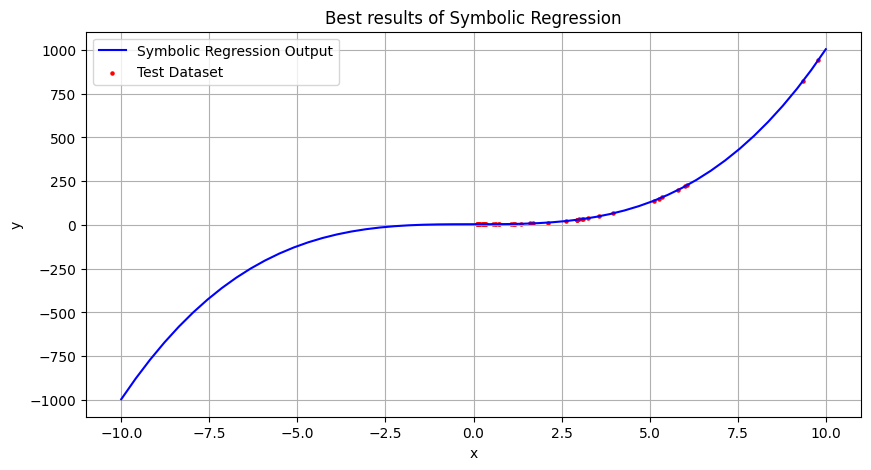

In [28]:
# Plot the results
plot_symbolic(x1_values, y_values, string_pred.replace("C", f'{C_opt:.4f}'))

In [29]:
# Second Dataset
C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

# Load data from the dataset.csv file
df = pd.read_csv("./dataset.csv")

# Create dataset with the correct shape (50, 7)
dataset = np.zeros((50, 7))

# Fill the dataset with values from the CSV file
dataset[:, 0] = df.iloc[:50, 0].values  # Output values
dataset[:, 1] = df.iloc[:50, 1].values  # First input variable
dataset[:, 2] = df.iloc[:50, 2].values  # Second input variable

# use evaluate function to find the expression
sympy_pred, string_pred = evaluate(dataset)
print(string_pred)

(x1)+(-((C)*(1/((x2)**2))))


In [30]:
# Parameter optimization using mse loss
f = sympy.lambdify((x1, x2, C), sympy_pred, "numpy")

# Define the MSE loss function
def mse_loss(C):
    predictions = f(dataset[:, 1], dataset[:, 2], C)
    return np.mean((y_values - predictions) ** 2)

C_opt = scipy.optimize.minimize_scalar(mse_loss).x
print(C_opt)

-4.34456045879725


In [31]:
print("final predicted expression:")
print(string_pred.replace("C", f'{C_opt:.4f}'))

final predicted expression:
(x1)+(-((-4.3446)*(1/((x2)**2))))


Accross different runs, I once received ((C)\*(x1))\*((x2)\*\*2). But it is not really stable. I dont have enough time to run several more times to get that result :)
